# Imports et chargement des données

In [1]:
import os
import gc
from datetime import datetime
from importlib import reload  
from copy import deepcopy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import roc_curve
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import fbeta_score
from sklearn.metrics import balanced_accuracy_score

from sklearn.model_selection import GridSearchCV
# from sklearn.svm import SVC
# from sklearn.linear_model import SGDClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.ensemble import GradientBoostingClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.naive_bayes import GaussianNB

# from imblearn.over_sampling import RandomOverSampler

import lightgbm as lgbm
from lightgbm import LGBMClassifier


# mes modules
import kagfonct as kf

In [2]:
plt.rcParams.update({"font.size" : 12, 'axes.titleweight':"bold", 'axes.labelweight': 'bold', \
                     "figure.figsize":[10,8], "savefig.bbox":"tight"})


In [3]:
PATH = "./data/"
for fic in os.listdir(PATH):
    print(fic)
# print(os.listdir(path))   

application_test.csv
application_train.csv
bureau.csv
bureau_balance.csv
credit_card_balance.csv
HomeCredit_columns_description - Copy.csv
HomeCredit_columns_description - test.csv
HomeCredit_columns_description - utf8.csv
HomeCredit_columns_description.csv
HomeCredit_columns_description.ods
installments_payments.csv
POS_CASH_balance.csv
previous_application.csv
Projet+Mise+en+prod+-+home-credit-default-risk.zip
sample_submission.csv


In [4]:
df_application_test = pd.read_csv(PATH+"application_test.csv")
df_application_train = pd.read_csv(PATH+"application_train.csv")
df_bureau = pd.read_csv(PATH+"bureau.csv")
df_bureau_balance = pd.read_csv(PATH+"bureau_balance.csv")
df_credit_card_balance = pd.read_csv(PATH+"credit_card_balance.csv")
df_payments = pd.read_csv(PATH+"installments_payments.csv")
df_pos_cash_balance = pd.read_csv(PATH+"POS_CASH_balance.csv")
df_prev_app = pd.read_csv(PATH+"previous_application.csv")
# df_homecredit = pd.read_csv(PATH+"HomeCredit_columns_description - utf8.csv")
df_homecredit = pd.read_csv(PATH+"HomeCredit_columns_description.csv", encoding = "cp1252")

NB : le fichier "HomeCredit_columns_description.csv" comporte à plusieurs reprises, un caractère qui n'est pas dans la norme utf-8 (…)

In [5]:
df_homecredit.loc[12,"Description"]

'Clients income type (businessman, working, maternity leave,…)'

# Fonctions

In [6]:
def conf_matrix(y_true, y_pred, seuil, verbose=True): 
    """
    input :
    y_true : vecteur de la classification attendue (classification binaire)
    y_pred : score prédit
    seuil : seuil pour décider qu'un score est positif
    
    output :
    pour différents seuils :
    tn : vecteur des vrais négatifs
    fp : vecteur des faux positifs
    fn : vecteur des faux négatifs
    tp : vecteur des vrais positifs
    fpr : taux de faux positifs
    fnr : taux de faux négatifs
    precision
    recall
    
    """
#     fpr, tpr, th = roc_curve(y_true, y_pred)
    tp = []
    tn = []
    fn = []
    fp = []
    scores = []
    c_pred = (y_pred >= seuil).astype(int) #class prediction
    tp = ((c_pred==1) & (y_true==1)).sum()
    tn = ((c_pred==0) & (y_true==0)).sum()
    fn = ((c_pred==0) & (y_true==1)).sum()
    fp = ((c_pred==1) & (y_true==0)).sum()
    fpr = fp/(fp+tn)
    fnr = fn/(fn+tp)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    
    if verbose :
        print("tp : ", tp)
        print("tn : ", tn)
        print("fp : ", fp)
        print("fn : ", fn)
        print(f"fpr = {fpr*100:.2f}%")
        print(f"fnr = {fnr*100:.2f}%")
        print(f"precision = {precision*100:.2f}%")
        print(f"recall = {recall*100:.2f}%")


    return tn, fp, fn, tp, fpr, fnr, precision, recall
    


In [7]:
def to_labels(preds, threshold):
    return (preds >= threshold).astype(int)

In [8]:
def matthews_eval(preds, train_data):
#     seuil = 0.5
    y_true = train_data.get_label()
#     c_pred = (preds >= seuil)
#     score = matthews_corrcoef(y_true, c_pred)
    thresholds = np.arange(0,1, 0.01)
    scores = [matthews_corrcoef(y_true, to_labels(preds, t)) for t in thresholds]
    idx = np.argmax(scores)
    score  = scores[idx]
#     print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores[ix]))
    
#     return eval_name, eval_result, is_higher_better    
    return "matthews_eval", score, True



In [9]:
# def fbeta_eval(preds, train_data):
#     beta = 0.5
#     seuil = 0.5
#     y_true = train_data.get_label()
#     c_pred = (preds >= seuil)
#     score = fbeta_score(y_true, c_pred, beta=beta)
#     return "fbeta_eval", score, True


In [10]:
def fbeta_eval2(preds, train_data):
    beta = 2
    y_true = train_data.get_label()
    thresholds = np.arange(0,1, 0.01)
    scores = [fbeta_score(y_true, to_labels(preds, t), beta=beta) for t in thresholds]
    idx = np.argmax(scores)
    score  = scores[idx]

#     print(idx, score)
    return "fbeta_eval2", score, True


In [11]:
def fbeta_eval3(preds, train_data):
    beta = 3
    y_true = train_data.get_label()
    thresholds = np.arange(0,1, 0.01)
    scores = [fbeta_score(y_true, to_labels(preds, t), beta=beta) for t in thresholds]
    idx = np.argmax(scores)
    score  = scores[idx]

#     print(idx, score)
    return "fbeta_eval3", score, True


In [12]:
def fbeta_eval3_95(preds, train_data):
    beta = 3.95
    y_true = train_data.get_label()
    thresholds = np.arange(0,1, 0.01)
    scores = [fbeta_score(y_true, to_labels(preds, t), beta=beta) for t in thresholds]
    idx = np.argmax(scores)
    score  = scores[idx]

#     print(idx, score)
    return "fbeta_eval3_95", score, True


In [13]:
def fbeta_eval4(preds, train_data):
    beta = 4
    y_true = train_data.get_label()
    thresholds = np.arange(0,1, 0.01)
    scores = [fbeta_score(y_true, to_labels(preds, t), beta=beta) for t in thresholds]
    idx = np.argmax(scores)
    score  = scores[idx]

#     print(idx, score)
    return "fbeta_eval4", score, True


In [14]:
def fbeta_eval0_5(preds, train_data):
    beta = 0.5
    y_true = train_data.get_label()
    thresholds = np.arange(0,1, 0.01)
    scores = [fbeta_score(y_true, to_labels(preds, t), beta=beta) for t in thresholds]
    idx = np.argmax(scores)
    score  = scores[idx]

#     print(idx, score)
    return "fbeta_eval0_5", score, True


In [15]:
def eval_auc(preds, train_data):
    y_true = train_data.get_label()
    fpr, tpr, th = roc_curve(y_true, preds)
    score =  auc(fpr, tpr)
    return "eval_auc", score, True


In [16]:
def eval_average_precision(preds, train_data):
    y_true = train_data.get_label()
    score = average_precision_score(y_true, preds)
    return "eval_average_precision", score, True

In [17]:
def eval_balanced_accuracy_score(preds, train_data):
    y_true = train_data.get_label()
    thresholds = np.arange(0,1, 0.01)
    scores = [balanced_accuracy_score(y_true, to_labels(preds, t)) for t in thresholds]
    idx = np.argmax(scores)
    score  = scores[idx]
    return "eval_balanced_accuracy_score", score, True    

In [18]:
def eval_Kulczynski_mod(preds, train_data):
    lambd = 0.4
    y_true = train_data.get_label()
    scores = []
    
    for seuil in np.arange(0,1, 0.01):
        score = Kulczynski_mod_score(y_true, preds, seuil, lambd)
#         tn, fp, fn, tp, fpr, fnr, precision, recall = conf_matrix(y_true, preds, seuil, verbose=False)
#         score = lambd*precision + (1-lambd)*recall
        scores.append(score)
    idx = np.argmax(scores[1:])
    score  = scores[idx]
    return "eval_Kulczynski_mod", score, True

In [19]:
def Kulczynski_mod_score(y_true, preds, seuil, lambd):
    tn, fp, fn, tp, fpr, fnr, precision, recall = conf_matrix(y_true, preds, seuil, verbose=False)
    score = lambd*precision + (1-lambd)*recall   
    return score

In [20]:
def eval_perso1(preds, train_data):
    lambd = 0.5
    mu = 0.5
    y_true = train_data.get_label()
    scores = []
    
    for seuil in np.arange(0,1, 0.001):
        score = perso1_score(y_true, preds, seuil, lambd, mu)
#         tn, fp, fn, tp, fpr, fnr, precision, recall = conf_matrix(y_true, preds, seuil, verbose=False)
#         score = tp/(lambd*tp + (1-lambd)*fp) + tp/(mu*tp + (1-mu)*fn)
        scores.append(score)
    idx = np.argmax(scores)
    score  = scores[idx]
    return "eval_perso1", score, True    

In [21]:
def perso1_score(y_true, preds, seuil, lambd, mu):
        tn, fp, fn, tp, fpr, fnr, precision, recall = conf_matrix(y_true, preds, seuil, verbose=False)
        score = tp/(lambd*tp + (1-lambd)*fp) + tp/(mu*tp + (1-mu)*fn)
        print(seuil, tn, fp, fn, tp, score)
        return score

In [22]:
def eval_tanimoto_mod(preds, train_data):
    y_true = train_data.get_label()
    scores = []
    for seuil in np.arange(0,1, 0.01):
        score = tanimoto_mod_score(y_true, preds, seuil)
        scores.append(score)
    idx = np.argmax(scores)
    score  = scores[idx]
    return "eval_tanimoto_mod", score, True    

In [23]:
def tanimoto_mod_score(y_true, preds, seuil):
#     print(y_true)
#     print(preds)
    tn, fp, fn, tp, fpr, fnr, precision, recall = conf_matrix(y_true, preds, seuil, verbose=False)
    score = (tp+tn) / (tp + 2*fp + 20*fn + tn)
#     print(seuil, tn, fp, fn, tp, score)
    return score

# Exploration

In [24]:
df_application_train.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


In [25]:
df_application_train.sample(10)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
218920,353619,0,Revolving loans,F,N,N,1,112500.0,337500.0,16875.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,5.0
286667,432024,0,Cash loans,F,Y,Y,0,108000.0,942300.0,27679.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
248655,387680,0,Cash loans,F,N,Y,0,76500.0,459000.0,14805.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
169323,296249,0,Cash loans,F,N,N,0,90000.0,81000.0,7555.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
262412,403780,0,Cash loans,F,N,N,0,225000.0,1350000.0,39474.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
255234,395331,0,Cash loans,M,Y,Y,2,292500.0,900000.0,26316.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
266987,409333,0,Cash loans,M,N,N,0,225000.0,286704.0,26424.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
295888,442809,0,Cash loans,M,N,N,1,180000.0,1546020.0,45333.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
270050,412974,0,Cash loans,F,N,Y,0,135000.0,677664.0,31531.5,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,1.0
167534,294212,0,Cash loans,M,Y,Y,0,211500.0,1125000.0,37309.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0


In [26]:
# Nombre de colonnes ayant des valeurs nulles
(df_application_train.isnull().sum()>0).sum()

67

In [27]:
df_homecredit[df_homecredit["Table"]=="application_{train|test}.csv"]

,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN
...,...,...,...,...,...
117,120,application_{train|test}.csv,AMT_REQ_CREDIT_BUREAU_DAY,Number of enquiries to Credit Bureau about the...,NaN
118,121,application_{train|test}.csv,AMT_REQ_CREDIT_BUREAU_WEEK,Number of enquiries to Credit Bureau about the...,NaN
119,122,application_{train|test}.csv,AMT_REQ_CREDIT_BUREAU_MON,Number of enquiries to Credit Bureau about the...,NaN
120,123,application_{train|test}.csv,AMT_REQ_CREDIT_BUREAU_QRT,Number of enquiries to Credit Bureau about the...,NaN


In [28]:
list(df_homecredit.loc[(df_homecredit["Table"]=="application_{train|test}.csv") & (df_homecredit["Row"]=="TARGET"), 
                       "Description"])

['Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)']

In [29]:
list(df_application_train.columns)

['SK_ID_CURR',
 'TARGET',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'WEEKDAY_APPR_PROCESS_START',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'YEARS_BUILD_MODE',
 'COMMONAREA_MODE',
 'ELEVATORS_MODE',
 'ENTRANCES_MODE',
 'FLOORSMAX_MODE',
 'FLOORSMIN_MODE',
 'LANDAREA_MODE',
 'LIVINGAPARTMENTS_MODE',
 'LIVINGAREA_MODE',
 'NONLIVINGAPARTMENTS_MODE',
 'NONLIVINGAREA_MODE',
 'APARTMENTS_MEDI',
 'BASEMENTAREA_MEDI',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'YEARS_BUILD_MEDI',
 'COMMONAREA_MEDI',
 'ELEVATORS_MEDI',
 'ENTRANCES_MEDI',
 'FLOORSMAX_MEDI',
 'FLOORSMIN_MEDI',
 'LANDAREA_MEDI',
 'LIVINGAPARTMENTS_MEDI',
 'LIVINGAREA_MEDI',
 'NONLIVINGAPARTMENTS_MEDI',
 'NONLIVINGAREA_MEDI',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'TOTALAREA_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'DAYS_LAST_PHONE_CHANGE',
 'FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_8',
 'FLAG_DOCUMENT_9',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_12',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT_16',
 'FLAG_DOCUMENT_17',
 'FLAG_DOCUMENT_18',
 'FLAG_DOCUMENT_19',
 'FLAG_DOCUMENT_20',
 'FLAG_DOCUMENT_21',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR']

In [30]:
df_application_test.sample(10)

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
40109,395448,Cash loans,F,Y,Y,0,360000.0,495882.0,39307.5,405000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0
20614,249532,Cash loans,F,Y,Y,1,135000.0,121500.0,12757.5,121500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
13907,200534,Cash loans,F,Y,Y,0,202500.0,270000.0,32170.5,270000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0
46346,438808,Cash loans,F,N,N,0,135000.0,351792.0,15624.0,252000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0
45813,434816,Cash loans,M,Y,N,1,112500.0,792162.0,42970.5,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
2702,118951,Cash loans,F,N,Y,0,225000.0,547272.0,33610.5,495000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,2.0,0.0
33744,346166,Cash loans,F,N,Y,0,225000.0,522396.0,30118.5,472500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
45203,430992,Cash loans,M,Y,N,0,103500.0,225000.0,9661.5,225000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,3.0
42027,407633,Cash loans,M,N,Y,0,225000.0,278460.0,21676.5,225000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,6.0
24098,275511,Cash loans,M,N,N,0,112500.0,180000.0,14220.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0


In [31]:
df_bureau.sample(10)

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
188449,230769,5786528,Active,currency 1,-490,0,1340.0,NaN,0.0,0,5796000.0,4747108.5,0.0,0.0,Consumer credit,-23,NaN
69891,156042,5246405,Closed,currency 1,-724,0,-482.0,-482.0,0.0,0,44890.2,0.0,0.0,0.0,Consumer credit,-480,NaN
956539,306072,6240025,Closed,currency 1,-2139,0,-1409.0,-1525.0,NaN,0,391356.0,0.0,NaN,0.0,Car loan,-1525,NaN
663951,388585,5016244,Closed,currency 1,-1695,0,-783.0,-965.0,NaN,0,471208.5,NaN,NaN,0.0,Consumer credit,-963,NaN
775013,188405,5419094,Closed,currency 1,-1889,0,-1744.0,-1744.0,NaN,0,25929.0,NaN,NaN,0.0,Consumer credit,-1744,NaN
1369253,316766,6711448,Active,currency 1,-607,0,1219.0,NaN,NaN,0,382500.0,298647.0,0.0,0.0,Consumer credit,-26,5886.000
1002413,245694,5454758,Active,currency 1,-389,0,344.0,NaN,NaN,0,142447.5,74353.5,0.0,0.0,Consumer credit,-11,NaN
834062,216074,6636609,Closed,currency 1,-1595,0,-1434.0,-1465.0,NaN,0,73372.5,0.0,0.0,0.0,Consumer credit,-1464,21558.375
39894,230717,5209458,Closed,currency 1,-1749,0,-1566.0,-1565.0,NaN,0,13644.0,0.0,0.0,0.0,Consumer credit,-1550,NaN
984934,321583,5075250,Closed,currency 1,-805,0,-440.0,-623.0,NaN,0,93654.0,NaN,NaN,0.0,Consumer credit,-599,NaN


In [32]:
# Nombre de colonnes ayant des valeurs nulles
(df_bureau.isnull().sum()>0).sum()

7

In [33]:
df_bureau[df_bureau["SK_ID_CURR"]==368092]

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
514934,368092,6457783,Closed,currency 1,-487,0,-122.0,-121.0,NaN,0,114750.0,0.0,0.0,0.0,Consumer credit,-116,0.0
514935,368092,6457784,Closed,currency 1,-1676,0,-580.0,-1505.0,NaN,0,270000.0,0.0,0.0,0.0,Consumer credit,-1423,5044.5
514936,368092,6457785,Closed,currency 1,-1676,0,-580.0,-610.0,NaN,0,270000.0,0.0,0.0,0.0,Consumer credit,-339,0.0
514937,368092,6457786,Closed,currency 1,-1819,0,-1547.0,-1197.0,NaN,0,83385.0,NaN,NaN,0.0,Consumer credit,-1194,0.0


In [34]:
df_bureau_balance[df_bureau_balance["SK_ID_BUREAU"]== 6457783]

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
10396161,6457783,0,C
10396162,6457783,-1,C
10396163,6457783,-2,C
10396164,6457783,-3,C
10396165,6457783,-4,C
10396166,6457783,-5,0
10396167,6457783,-6,0
10396168,6457783,-7,0
10396169,6457783,-8,X
10396170,6457783,-9,0


In [35]:
df_bureau_balance["STATUS"].unique()

array(['C', '0', 'X', '1', '2', '3', '5', '4'], dtype=object)

In [36]:
# Nombre de colonnes ayant des valeurs nulles
(df_bureau_balance.isnull().sum()>0).sum()

0

In [37]:
df_homecredit[df_homecredit["Table"]=="bureau_balance.csv"]

,Unnamed: 0,Table,Row,Description,Special
139,142,bureau_balance.csv,SK_BUREAU_ID,Recoded ID of Credit Bureau credit (unique cod...,hashed
140,143,bureau_balance.csv,MONTHS_BALANCE,Month of balance relative to application date ...,time only relative to the application
141,144,bureau_balance.csv,STATUS,Status of Credit Bureau loan during the month ...,NaN


In [38]:
df_pos_cash_balance[df_pos_cash_balance["SK_ID_CURR"]==368092].sort_values(by="MONTHS_BALANCE")

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
9535021,2198792,368092,-82,12.0,12.0,Active,0,0
948279,2198792,368092,-81,12.0,11.0,Active,0,0
9001077,2198792,368092,-80,12.0,10.0,Active,0,0
6410934,2198792,368092,-79,12.0,9.0,Active,0,0
4157178,2198792,368092,-78,12.0,8.0,Active,0,0
4097603,2198792,368092,-77,12.0,7.0,Active,0,0
1377294,2198792,368092,-76,12.0,6.0,Active,0,0
2462432,2198792,368092,-75,12.0,5.0,Active,0,0
3171983,2198792,368092,-74,12.0,4.0,Active,0,0
3216998,2198792,368092,-73,12.0,3.0,Active,0,0


In [39]:
# Nombre de colonnes ayant des valeurs nulles
(df_pos_cash_balance.isnull().sum()>0).sum()

2

In [40]:
df_homecredit[df_homecredit["Table"]=="POS_CASH_balance.csv"]

,Unnamed: 0,Table,Row,Description,Special
142,145,POS_CASH_balance.csv,SK_ID_PREV,ID of previous credit in Home Credit related t...,NaN
143,146,POS_CASH_balance.csv,SK_ID_CURR,ID of loan in our sample,NaN
144,147,POS_CASH_balance.csv,MONTHS_BALANCE,Month of balance relative to application date ...,time only relative to the application
145,148,POS_CASH_balance.csv,CNT_INSTALMENT,Term of previous credit (can change over time),NaN
146,149,POS_CASH_balance.csv,CNT_INSTALMENT_FUTURE,Installments left to pay on the previous credit,NaN
147,150,POS_CASH_balance.csv,NAME_CONTRACT_STATUS,Contract status during the month,NaN
148,151,POS_CASH_balance.csv,SK_DPD,DPD (days past due) during the month of previo...,NaN
149,152,POS_CASH_balance.csv,SK_DPD_DEF,DPD during the month with tolerance (debts wit...,NaN


In [41]:
df_credit_card_balance.sample(10)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
31069,1316354,403898,-61,174968.010,180000,0.0,0.00,0.0,0.00,9000.000,...,174968.010,174968.010,0.0,0,0.0,0.0,35.0,Active,0,0
336108,2116470,165471,-4,281476.980,270000,0.0,6195.24,0.0,6195.24,13899.420,...,279446.715,279446.715,0.0,9,0.0,9.0,5.0,Active,0,0
2728210,1999824,138870,-85,175856.130,180000,0.0,0.00,0.0,0.00,9000.000,...,175856.130,175856.130,0.0,0,0.0,0.0,17.0,Active,0,0
2097115,1570242,128496,-4,0.000,180000,0.0,0.00,0.0,0.00,0.000,...,0.000,0.000,0.0,0,0.0,0.0,23.0,Completed,0,0
1324107,2445988,383225,-40,108388.665,135000,0.0,0.00,0.0,0.00,6750.000,...,108388.665,108388.665,0.0,0,0.0,0.0,36.0,Active,0,0
1128712,1171394,367226,-50,130238.910,135000,0.0,0.00,0.0,0.00,6750.000,...,130238.910,130238.910,0.0,0,0.0,0.0,34.0,Active,0,0
2409903,2459735,429962,-1,183643.650,675000,67500.0,67500.00,0.0,0.00,5746.725,...,180787.680,180787.680,1.0,1,0.0,0.0,6.0,Active,0,0
1670207,2391603,301645,-79,0.000,90000,0.0,0.00,0.0,0.00,0.000,...,0.000,0.000,0.0,0,0.0,0.0,17.0,Active,0,0
873583,2353799,425476,-9,0.000,90000,0.0,0.00,0.0,0.00,0.000,...,0.000,0.000,0.0,0,0.0,0.0,42.0,Completed,0,0
1434456,2032381,426467,-2,0.000,135000,0.0,0.00,0.0,0.00,0.000,...,0.000,0.000,0.0,0,0.0,0.0,0.0,Completed,0,0


In [42]:
# Nombre de colonnes ayant des valeurs nulles
(df_credit_card_balance.isnull().sum()>0).sum()

9

In [43]:
df_prev_app.sample(10)

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
59382,1965247,206009,Cash loans,NaN,0.00,0.0,NaN,NaN,WEDNESDAY,17,...,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
1373033,1341923,211469,Cash loans,12989.340,252000.00,291915.0,NaN,252000.00,TUESDAY,11,...,XNA,36.0,middle,Cash X-Sell: middle,NaN,NaN,NaN,NaN,NaN,NaN
475479,2364127,402234,Consumer loans,18437.400,488022.21,488020.5,1.71,488022.21,SATURDAY,14,...,Consumer electronics,36.0,low_normal,POS household with interest,NaN,NaN,NaN,NaN,NaN,NaN
728407,1812251,244573,Consumer loans,13159.755,74475.00,74475.0,0.00,74475.00,MONDAY,15,...,Clothing,6.0,low_normal,POS industry with interest,365243.0,-1441.0,-1291.0,-1291.0,-1270.0,0.0
1654949,1046335,124706,Cash loans,NaN,0.00,0.0,NaN,NaN,TUESDAY,18,...,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
410131,2269863,428711,Revolving loans,45000.000,900000.00,900000.0,NaN,900000.00,TUESDAY,13,...,XNA,0.0,XNA,Card X-Sell,365243.0,365243.0,365243.0,365243.0,-197.0,0.0
1303891,1942430,188492,Cash loans,NaN,0.00,0.0,NaN,NaN,THURSDAY,10,...,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
1312562,2596525,446696,Cash loans,20662.875,184500.00,196677.0,NaN,184500.00,SUNDAY,15,...,XNA,12.0,middle,Cash X-Sell: middle,NaN,NaN,NaN,NaN,NaN,NaN
370898,1527920,217450,Cash loans,44163.720,1305000.00,1456587.0,NaN,1305000.00,MONDAY,9,...,XNA,48.0,low_action,Cash X-Sell: low,NaN,NaN,NaN,NaN,NaN,NaN
32344,1707658,375463,Cash loans,26891.910,135000.00,139455.0,NaN,135000.00,TUESDAY,11,...,XNA,6.0,middle,Cash X-Sell: middle,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
# Nombre de colonnes ayant des valeurs nulles
(df_prev_app.isnull().sum()>0).sum()

16

In [45]:
df_prev_app[df_prev_app["SK_ID_CURR"]==368092]

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
132593,2198792,368092,Consumer loans,5921.37,122764.14,60732.0,67504.14,122764.14,MONDAY,13,...,Consumer electronics,12.0,middle,POS household with interest,365243.0,-2475.0,-2145.0,-2145.0,-2136.0,1.0


In [46]:
df_payments.sample(10)

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
13336019,2829926,416136,0.0,77,-1305.0,-1315.0,10800.000,10800.000
11428218,1442467,390954,1.0,2,-2160.0,-2163.0,29105.955,29105.955
7183122,1822179,238854,1.0,3,-1302.0,-1391.0,9410.445,9410.445
7456410,1683648,268237,1.0,5,-665.0,-670.0,5079.555,5079.555
12974543,1740511,410704,0.0,12,-2677.0,-2677.0,5782.320,5782.320
6763772,1108831,214636,1.0,6,-489.0,-496.0,27722.430,27722.430
11478420,2539361,339757,1.0,14,-456.0,-457.0,41720.940,41720.940
2693682,2652177,168616,1.0,6,-151.0,-191.0,3703.815,3703.815
11324015,2652756,379657,0.0,73,-905.0,-905.0,196.965,196.965
5632910,1365651,220682,1.0,19,-421.0,-426.0,6001.920,6001.920


In [47]:
# Nombre de colonnes ayant des valeurs nulles
(df_payments.isnull().sum()>0).sum()

2

In [48]:
df_payments[df_payments["SK_ID_CURR"]==368092].sort_values(by="NUM_INSTALMENT_NUMBER")

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
8624343,2198792,368092,1.0,1,-2475.0,-2485.0,5921.37,5921.37
8085854,2198792,368092,1.0,2,-2445.0,-2447.0,5921.37,5921.37
9254042,2198792,368092,1.0,3,-2415.0,-2419.0,5921.37,5921.37
7829329,2198792,368092,1.0,4,-2385.0,-2387.0,5921.37,5921.37
9254285,2198792,368092,1.0,5,-2355.0,-2358.0,5921.37,5921.37
10778313,2198792,368092,1.0,6,-2325.0,-2344.0,5921.37,5921.37
9235293,2198792,368092,1.0,7,-2295.0,-2296.0,5921.37,5921.37
8320158,2198792,368092,1.0,8,-2265.0,-2274.0,5921.37,5921.37
11155326,2198792,368092,1.0,9,-2235.0,-2246.0,5921.37,5921.37
11034595,2198792,368092,1.0,10,-2205.0,-2204.0,5921.37,5921.37


# Feature Engineering

## Intégration des données

In [49]:
reload(kf)

<module 'kagfonct' from 'D:\\Laure\\AnacondaProjects\\20 - openclassrooms\\10 - parcoursDS\\7 - Scoring\\modelisation\\kagfonct.py'>

In [50]:
data, y = kf.build_model_input(PATH)

Buro bal shape :  (27299925, 3)
transform to dummies
Counting buros
averaging buro bal
Read Bureau
Go to dummies
Merge with buro avg
Counting buro per SK_ID_CURR
Averaging bureau
            SK_ID_BUREAU  DAYS_CREDIT  CREDIT_DAY_OVERDUE  \
SK_ID_CURR                                                  
100001               7.0  -735.000000                 0.0   
100002               8.0  -874.000000                 0.0   
100003               4.0 -1400.750000                 0.0   
100004               2.0  -867.000000                 0.0   
100005               3.0  -190.666667                 0.0   

            DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  AMT_CREDIT_MAX_OVERDUE  \
SK_ID_CURR                                                                   
100001                82.428571        -825.500000                     NaN   
100002              -349.000000        -697.500000                1681.029   
100003              -544.500000       -1097.333333                   0.000   
100

Go to dummies
Compute nb of prevs per curr
Go to averages
Reading CC balance
Go to dummies
Compute average
Reading Installments
Read data
Shapes :  (307511, 122)


In [51]:
data["DAYS_EMPLOYED"].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

In [52]:
(data["DAYS_EMPLOYED"]==365243).sum()

55374

In [53]:
data["DAYS_EMPLOYED"].quantile(0.81)

-116.0

In [54]:
data.loc[data["DAYS_EMPLOYED"]>0, "DAYS_EMPLOYED"].value_counts()

365243    55374
Name: DAYS_EMPLOYED, dtype: int64

Nous remarquons que "DAYS_EMPLOYED" contient surtout des valeurs des valeurs négatives. Il n'y a qu'une seule valeur positive qui correpond à une durée de 1000 ans. Nous supposons que cette valeur correspond aux personnes soit qui n'ont pas de travail, soit pour lesquelles il n'y a pas d'information. Nous allons remplacer cette valeur par null.  
De plus, nous allons rendre prositives les valeurs de cette colonne.

In [55]:
data.loc[data["DAYS_EMPLOYED"]>0, "DAYS_EMPLOYED"] = np.nan

In [56]:
data["DAYS_EMPLOYED"] = -data["DAYS_EMPLOYED"]

In [57]:
# suppression des colonnes qui sont en fait des indexes
applicants = data["SK_ID_CURR"]
data.drop(columns = [x for x in list(data.columns) if 'SK_ID' in x], inplace=True)

In [58]:
df_data_true = pd.concat([pd.Series(y, name="risk"), data], axis=1)
df_data_true

,risk,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,cc_bal_cc_bal_status__Demand,cc_bal_cc_bal_status__Refused,cc_bal_cc_bal_status__Sent_proposal,cc_bal_cc_bal_status__Signed,inst_NUM_INSTALMENT_VERSION,inst_NUM_INSTALMENT_NUMBER,inst_DAYS_INSTALMENT,inst_DAYS_ENTRY_PAYMENT,inst_AMT_INSTALMENT,inst_AMT_PAYMENT
0,1,0,0,0,0,0,202500.0,406597.5,24700.5,351000.0,...,NaN,NaN,NaN,NaN,1.052632,10.000000,-295.000000,-315.421053,11559.247105,11559.247105
1,0,0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,...,NaN,NaN,NaN,NaN,1.040000,5.080000,-1378.160000,-1385.320000,64754.586000,64754.586000
2,0,1,0,1,0,0,67500.0,135000.0,6750.0,135000.0,...,NaN,NaN,NaN,NaN,1.333333,2.000000,-754.000000,-761.666667,7096.155000,7096.155000
3,0,0,1,0,0,0,135000.0,312682.5,29686.5,297000.0,...,0.0,0.0,0.0,0.0,1.125000,4.437500,-252.250000,-271.625000,62947.088438,62947.088438
4,0,0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,...,NaN,NaN,NaN,NaN,1.166667,7.045455,-1028.606061,-1032.242424,12666.444545,12214.060227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,0,0,0,0,1,0,157500.0,254700.0,27558.0,225000.0,...,NaN,NaN,NaN,NaN,1.142857,4.000000,-120.000000,-156.285714,7492.924286,7492.924286
307507,0,0,1,0,0,0,72000.0,269550.0,12001.5,225000.0,...,NaN,NaN,NaN,NaN,1.000000,3.500000,-2391.000000,-2393.833333,10069.867500,10069.867500
307508,0,0,1,0,0,0,153000.0,677664.0,29979.0,585000.0,...,NaN,NaN,NaN,NaN,1.000000,4.785714,-2372.928571,-2387.428571,4399.707857,4115.915357
307509,1,0,1,0,0,0,171000.0,370107.0,20205.0,319500.0,...,NaN,NaN,NaN,NaN,1.000000,5.263158,-142.263158,-161.263158,10239.832895,10239.832895


## Analyse du résultat

In [59]:
print("taille des données : ", data.shape)
print("taille des prévisions : ", y.shape)

taille des données :  (307511, 374)
taille des prévisions :  (307511,)


In [60]:
y.value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

In [61]:
print(f"pourcentage de personnes ayant des difficultés de paiement : {(y==1).sum()/len(y)*100:.1f}%")

pourcentage de personnes ayant des difficultés de paiement : 8.1%


In [62]:
data.sample(10)

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,cc_bal_cc_bal_status__Demand,cc_bal_cc_bal_status__Refused,cc_bal_cc_bal_status__Sent_proposal,cc_bal_cc_bal_status__Signed,inst_NUM_INSTALMENT_VERSION,inst_NUM_INSTALMENT_NUMBER,inst_DAYS_INSTALMENT,inst_DAYS_ENTRY_PAYMENT,inst_AMT_INSTALMENT,inst_AMT_PAYMENT
280702,0,1,1,0,0,171000.0,639396.0,30888.0,571500.0,0,...,0.0,0.0,0.0,0.0,0.358108,45.418919,-1428.398649,-1430.472973,15799.595473,18718.785912
120785,0,1,0,1,0,157500.0,1288350.0,37800.0,1125000.0,0,...,0.0,0.0,0.0,0.0,0.255208,66.369792,-1219.484375,-1228.187500,12111.551484,11796.292266
127665,0,1,0,0,2,157500.0,653328.0,21204.0,468000.0,0,...,0.0,0.0,0.0,0.0,0.766667,7.200000,-298.183333,-319.200000,14007.164250,13751.654250
7655,0,0,1,1,1,180000.0,382500.0,25560.0,382500.0,0,...,NaN,NaN,NaN,NaN,1.000000,3.500000,-604.000000,-609.333333,12021.660000,12021.660000
15083,0,0,1,0,0,157500.0,225000.0,24363.0,225000.0,0,...,NaN,NaN,NaN,NaN,1.000000,5.500000,-464.000000,-476.600000,11947.716000,11947.716000
251946,0,1,0,0,0,180000.0,679500.0,36333.0,679500.0,0,...,NaN,NaN,NaN,NaN,1.181818,3.818182,-360.545455,-382.727273,13003.887273,13003.887273
118404,0,0,0,0,2,202500.0,983299.5,41791.5,904500.0,0,...,NaN,NaN,NaN,NaN,1.058824,5.470588,-1369.352941,-1387.411765,6806.636471,6806.636471
232377,0,1,0,0,0,180000.0,1303812.0,35982.0,1138500.0,1,...,NaN,NaN,NaN,NaN,1.025641,5.282051,-1542.230769,-1548.615385,26663.224615,26663.224615
174121,0,1,0,1,0,126000.0,272520.0,16803.0,225000.0,0,...,NaN,NaN,NaN,NaN,2.935065,9.155844,-960.285714,-966.896104,21999.913247,23924.258766
43204,0,0,1,0,0,180000.0,495216.0,30055.5,427500.0,0,...,0.0,0.0,0.0,0.0,0.555556,19.444444,-389.402778,-394.166667,14248.143750,16941.434375


## Valeurs nulles

Pour le traitement des valeurs nulles, nous devons tenir compte du fait que le taux de personnes ayant des difficultés de paiement est de 8%. Il ne faut donc pas supprimer trop rapidement des valeurs qui pourraient être significatives pour ces personnes.

In [63]:
data.isnull().sum().sort_values(ascending=False)

RATE_INTEREST_PRIVILEGED           302902
RATE_INTEREST_PRIMARY              302902
cc_bal_AMT_PAYMENT_CURRENT         246451
cc_bal_AMT_DRAWINGS_ATM_CURRENT    246371
cc_bal_CNT_DRAWINGS_POS_CURRENT    246371
                                    ...  
REG_CITY_NOT_WORK_CITY                  0
HOUSETYPE_MODE                          0
LIVE_REGION_NOT_WORK_REGION             0
REG_REGION_NOT_WORK_REGION              0
NAME_CONTRACT_TYPE                      0
Length: 374, dtype: int64

In [64]:
# Nombre de colonnes ayant des valeurs nulles
(data.isnull().sum()>0).value_counts()

True     316
False     58
dtype: int64

In [65]:
# Nombre de lignes ayant des valeurs nulles
(data.isnull().sum(axis=1)>0).value_counts()

True     307494
False        17
dtype: int64

In [66]:
# Nombre de colonnes ayant moins de 1% de valeurs nulles
((data.isnull().sum()/data.count()*100)<1).value_counts()

False    307
True      67
dtype: int64

In [67]:
data.describe()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,cc_bal_cc_bal_status__Demand,cc_bal_cc_bal_status__Refused,cc_bal_cc_bal_status__Sent_proposal,cc_bal_cc_bal_status__Signed,inst_NUM_INSTALMENT_VERSION,inst_NUM_INSTALMENT_NUMBER,inst_DAYS_INSTALMENT,inst_DAYS_ENTRY_PAYMENT,inst_AMT_INSTALMENT,inst_AMT_PAYMENT
count,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,...,86905.000000,86905.000000,86905.000000,86905.000000,291643.000000,291643.000000,291643.000000,291635.000000,2.916430e+05,2.916350e+05
mean,0.095213,0.658370,0.340108,0.306327,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.277512,...,0.000106,0.000002,0.000064,0.003738,1.041501,9.764795,-909.662335,-920.961181,1.839261e+04,1.875431e+04
std,0.293509,0.474284,0.473746,0.460968,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.722458,...,0.008740,0.000155,0.000877,0.031882,0.602107,11.273675,598.461681,597.024650,2.333797e+04,2.510536e+04
min,0.000000,0.000000,0.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,-1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-2922.000000,-3071.000000,0.000000e+00,1.890000e-01
25%,0.000000,0.000000,0.000000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,4.555556,-1301.959806,-1311.842195,7.799513e+03,7.478370e+03
50%,0.000000,1.000000,0.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.017241,6.045455,-795.953488,-807.581818,1.257265e+04,1.222576e+04
75%,0.000000,1.000000,1.000000,1.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.111111,9.434413,-419.000000,-431.609963,2.137614e+04,2.135286e+04
max,1.000000,2.000000,1.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,6.000000,...,0.915789,0.013889,0.024390,1.000000,39.000000,138.110063,-3.000000,-3.000000,2.504590e+06,2.504590e+06


In [68]:
data.mean()

NAME_CONTRACT_TYPE                0.095213
CODE_GENDER                       0.658370
FLAG_OWN_CAR                      0.340108
FLAG_OWN_REALTY                   0.306327
CNT_CHILDREN                      0.417052
                                  ...     
inst_NUM_INSTALMENT_NUMBER        9.764795
inst_DAYS_INSTALMENT           -909.662335
inst_DAYS_ENTRY_PAYMENT        -920.961181
inst_AMT_INSTALMENT           18392.611499
inst_AMT_PAYMENT              18754.310245
Length: 374, dtype: float64

Pour les classifiers n'acceptant pas les valeurs nulles, nous les remplaceront par la moyenne.  
Ce n'est pas le cas de LGBM Classifier.

# Prévisions

In [69]:
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.33, random_state=42)

Document sur les indices de similarité :  
http://iramuteq.org/documentation/detail-des-indices-de-similitude

## LGBMClassifier

In [70]:
eval_fonct = eval_average_precision
eval_fonct_score = precision_recall_curve
eval_fonct_str = "eval_average_precision"
eval_fonct_param1 = 0
eval_fonct_param2 = 0

In [71]:
%%time
print(f"Heure de début : {str(datetime.now())}")

lgbm_train = lgbm.Dataset(data=X_train,
                          label=y_train,
#                           categorical_feature=categorical_feats,
#                          free_raw_data=False
                         )
lgbm_valid = lgbm.Dataset(data=X_test,
                          label=y_test,
                         )


lgbm_params = {
'boosting': 'dart',
'application': 'binary',
'learning_rate': 0.1,
'min_data_in_leaf': 30,
'num_leaves': 31,
'max_depth': -1,
'feature_fraction': 0.5,
'scale_pos_weight': 1.4,
'drop_rate': 0.025,
# 'metrics': 'auc',
# 'class_weight': 'balanced',
# 'is_unbalance': True,
'reg_lambda' : 14,
'sigmoid' : 0.3
}

cv_results = lgbm.cv(train_set=lgbm_train,
             params=lgbm_params,
             nfold=5,
             num_boost_round=100,
#                          early_stopping_rounds=100,
             verbose_eval=10,
             feval = eval_fonct
#              metrics=['average_precision']
                    )

# optimum_boost_rounds = np.argmax(cv_results['auc-mean'])
# print('Optimum boost rounds = {}'.format(optimum_boost_rounds))
# print('Best CV result = {}'.format(np.max(cv_results['auc-mean'])))



Heure de début : 2020-04-24 16:45:33.343600
[10]	cv_agg's binary_logloss: 0.261927 + 0.000360427	cv_agg's eval_average_precision: 0.221367 + 0.00627461
[20]	cv_agg's binary_logloss: 0.25575 + 0.000596178	cv_agg's eval_average_precision: 0.233611 + 0.00673028
[30]	cv_agg's binary_logloss: 0.252888 + 0.000709247	cv_agg's eval_average_precision: 0.241138 + 0.00586264
[40]	cv_agg's binary_logloss: 0.251038 + 0.000769205	cv_agg's eval_average_precision: 0.246218 + 0.00582713
[50]	cv_agg's binary_logloss: 0.250194 + 0.000689186	cv_agg's eval_average_precision: 0.249791 + 0.0059975
[60]	cv_agg's binary_logloss: 0.24908 + 0.00073467	cv_agg's eval_average_precision: 0.253298 + 0.00648159
[70]	cv_agg's binary_logloss: 0.248318 + 0.000835934	cv_agg's eval_average_precision: 0.256133 + 0.00711482
[80]	cv_agg's binary_logloss: 0.24793 + 0.000882341	cv_agg's eval_average_precision: 0.257453 + 0.00693686
[90]	cv_agg's binary_logloss: 0.24778 + 0.000815095	cv_agg's eval_average_precision: 0.258518 + 0

In [72]:
eval_fonct_str

'eval_average_precision'

In [73]:
eval_fonct

<function __main__.eval_average_precision(preds, train_data)>

In [74]:
optimum_boost_rounds = np.argmax(cv_results[eval_fonct_str +'-mean'])
print('Optimum boost rounds = {}'.format(optimum_boost_rounds))
print('Best CV result = {}'.format(np.max(cv_results[eval_fonct_str + '-mean'])))


Optimum boost rounds = 99
Best CV result = 0.26110969211080187


**Résultats avec is_unbalance**  
lgbm_params = {
'boosting': 'dart',
'application': 'binary',
'learning_rate': 0.1,
'min_data_in_leaf': 30,
'num_leaves': 31,
'max_depth': -1,
'feature_fraction': 0.5,
'drop_rate': 0.025,
'metrics': 'auc',
'is_unbalance': True,
'reg_lambda' : 14,
'sigmoid' : 0.3
}

cv_results = lgbm.cv(train_set=lgbm_train,
             params=lgbm_params,
             nfold=5,
             num_boost_round=1000,
                          early_stopping_rounds=100,
             verbose_eval=100,
             metrics=['auc']
                    )  
                    
                    
[100]	cv_agg's auc: 0.77114 + 0.00260605
[200]	cv_agg's auc: 0.775329 + 0.00277529
[300]	cv_agg's auc: 0.777824 + 0.00282435
[400]	cv_agg's auc: 0.778755 + 0.00272432
[500]	cv_agg's auc: 0.779349 + 0.00250999
[600]	cv_agg's auc: 0.779549 + 0.00266121
[700]	cv_agg's auc: 0.779461 + 0.00267353
[800]	cv_agg's auc: 0.779466 + 0.00278914
[900]	cv_agg's auc: 0.779542 + 0.00284277
[1000]	cv_agg's auc: 0.779671 + 0.0028612
Optimum boost rounds = 986
Best CV result = 0.7797494433087251
Wall time: 3min 52s



**Variations de scale_pos_weight**  
for scale in np.linspace (1.2, 3, 10) : 
    lgbm_params = {
    'boosting': 'dart',
    'application': 'binary',
    'learning_rate': 0.1,
    'min_data_in_leaf': 30,
    'num_leaves': 31,
    'max_depth': -1,
    'feature_fraction': 0.5,
    'scale_pos_weight': scale,
    'drop_rate': 0.025,
    'metrics': 'auc',
    'class_weight': 'balanced',
    # 'is_unbalance': True,
    'reg_lambda' : 14,
    'sigmoid' : 0.3
    }

    cv_results = lgbm.cv(train_set=lgbm_train,
                 params=lgbm_params,
                 nfold=5,
                 num_boost_round=1000,
    #                          early_stopping_rounds=100,
                 verbose_eval=100,
                 metrics=['auc']
                        )

    optimum_boost_rounds = np.argmax(cv_results['auc-mean'])
    print('Optimum boost rounds = {}'.format(optimum_boost_rounds))
    print('Best CV result = {}'.format(np.max(cv_results['auc-mean'])))



Heure de début : 2020-04-14 11:28:15.187012
[100]	cv_agg's auc: 0.769767 + 0.00331941
[200]	cv_agg's auc: 0.772935 + 0.00344862
[300]	cv_agg's auc: 0.776687 + 0.00298045
[400]	cv_agg's auc: 0.778792 + 0.00286058
[500]	cv_agg's auc: 0.779526 + 0.00280973
[600]	cv_agg's auc: 0.780214 + 0.00291006
[700]	cv_agg's auc: 0.780316 + 0.00284064
[800]	cv_agg's auc: 0.780514 + 0.0027343
[900]	cv_agg's auc: 0.7805 + 0.00281825
[1000]	cv_agg's auc: 0.78041 + 0.00272825
Optimum boost rounds = 890
Best CV result = 0.7805579579825707
[100]	cv_agg's auc: 0.770749 + 0.00309585
[200]	cv_agg's auc: 0.774063 + 0.00338265
[300]	cv_agg's auc: 0.77736 + 0.00318675
[400]	cv_agg's auc: 0.778914 + 0.00310343
[500]	cv_agg's auc: 0.780063 + 0.00299021
[600]	cv_agg's auc: 0.780653 + 0.00293378
[700]	cv_agg's auc: 0.780839 + 0.00292982
[800]	cv_agg's auc: 0.780943 + 0.0030801
[900]	cv_agg's auc: 0.781118 + 0.0031577
[1000]	cv_agg's auc: 0.781108 + 0.00309517
Optimum boost rounds = 893
Best CV result = 0.7811757397112599
[100]	cv_agg's auc: 0.770534 + 0.00325684
[200]	cv_agg's auc: 0.773746 + 0.0030433
[300]	cv_agg's auc: 0.77694 + 0.00295683
[400]	cv_agg's auc: 0.778846 + 0.0025315
[500]	cv_agg's auc: 0.779553 + 0.00274158
[600]	cv_agg's auc: 0.780163 + 0.00259661
[700]	cv_agg's auc: 0.780464 + 0.00288203
[800]	cv_agg's auc: 0.780712 + 0.00309403
[900]	cv_agg's auc: 0.780745 + 0.0032112
[1000]	cv_agg's auc: 0.780769 + 0.00328433
Optimum boost rounds = 920
Best CV result = 0.7808296303070719
[100]	cv_agg's auc: 0.770662 + 0.00326064
[200]	cv_agg's auc: 0.77399 + 0.00316988
[300]	cv_agg's auc: 0.77717 + 0.00276563
[400]	cv_agg's auc: 0.77901 + 0.00273257
[500]	cv_agg's auc: 0.779651 + 0.00271691
[600]	cv_agg's auc: 0.780188 + 0.00288543
[700]	cv_agg's auc: 0.780462 + 0.00318229
[800]	cv_agg's auc: 0.780652 + 0.00322722
[900]	cv_agg's auc: 0.780585 + 0.00312511
[1000]	cv_agg's auc: 0.78059 + 0.00296092
Optimum boost rounds = 736
Best CV result = 0.780660218163799
[100]	cv_agg's auc: 0.771207 + 0.00286242
[200]	cv_agg's auc: 0.774668 + 0.00295244
[300]	cv_agg's auc: 0.777666 + 0.00266178
[400]	cv_agg's auc: 0.779503 + 0.00258824
[500]	cv_agg's auc: 0.779895 + 0.00294537
[600]	cv_agg's auc: 0.780533 + 0.00283984
[700]	cv_agg's auc: 0.780682 + 0.00294499
[800]	cv_agg's auc: 0.780604 + 0.00287269
[900]	cv_agg's auc: 0.780892 + 0.00285883
[1000]	cv_agg's auc: 0.780837 + 0.00294008
Optimum boost rounds = 892
Best CV result = 0.7808987781422839
[100]	cv_agg's auc: 0.771367 + 0.00288915
[200]	cv_agg's auc: 0.774619 + 0.00284786
[300]	cv_agg's auc: 0.777614 + 0.00283446
[400]	cv_agg's auc: 0.779433 + 0.00272813
[500]	cv_agg's auc: 0.779754 + 0.0027423
[600]	cv_agg's auc: 0.779998 + 0.00313448
[700]	cv_agg's auc: 0.780298 + 0.00312195
[800]	cv_agg's auc: 0.780431 + 0.00320818
[900]	cv_agg's auc: 0.780597 + 0.00327776
[1000]	cv_agg's auc: 0.78051 + 0.00335146
Optimum boost rounds = 852
Best CV result = 0.7806490864580116
[100]	cv_agg's auc: 0.77128 + 0.00269848
[200]	cv_agg's auc: 0.774866 + 0.00287929
[300]	cv_agg's auc: 0.777804 + 0.00274996
[400]	cv_agg's auc: 0.779104 + 0.00274491
[500]	cv_agg's auc: 0.779682 + 0.00267269
[600]	cv_agg's auc: 0.780054 + 0.00259557
[700]	cv_agg's auc: 0.780425 + 0.00236835
[800]	cv_agg's auc: 0.78056 + 0.00227788
[900]	cv_agg's auc: 0.780774 + 0.00231359
[1000]	cv_agg's auc: 0.780886 + 0.00220768
Optimum boost rounds = 943
Best CV result = 0.7809481566907682
[100]	cv_agg's auc: 0.771512 + 0.00294654
[200]	cv_agg's auc: 0.775132 + 0.00310352
[300]	cv_agg's auc: 0.777985 + 0.00269412
[400]	cv_agg's auc: 0.779316 + 0.00292535
[500]	cv_agg's auc: 0.779931 + 0.00309484
[600]	cv_agg's auc: 0.780423 + 0.00326247
[700]	cv_agg's auc: 0.780523 + 0.00317905
[800]	cv_agg's auc: 0.780725 + 0.00316547
[900]	cv_agg's auc: 0.780606 + 0.00325578
[1000]	cv_agg's auc: 0.780598 + 0.00286086
Optimum boost rounds = 813
Best CV result = 0.7807756138511386
[100]	cv_agg's auc: 0.77156 + 0.00278808
[200]	cv_agg's auc: 0.775348 + 0.0026809
[300]	cv_agg's auc: 0.778402 + 0.00270071
[400]	cv_agg's auc: 0.779611 + 0.00249691
[500]	cv_agg's auc: 0.780208 + 0.00268018
[600]	cv_agg's auc: 0.780495 + 0.00267814
[700]	cv_agg's auc: 0.78052 + 0.00271063
[800]	cv_agg's auc: 0.780574 + 0.00264194
[900]	cv_agg's auc: 0.780654 + 0.00282075
[1000]	cv_agg's auc: 0.780626 + 0.00274191
Optimum boost rounds = 864
Best CV result = 0.7807446773071025
[100]	cv_agg's auc: 0.771882 + 0.00285002
[200]	cv_agg's auc: 0.775212 + 0.00304469
[300]	cv_agg's auc: 0.777837 + 0.00249655
[400]	cv_agg's auc: 0.779026 + 0.00270292
[500]	cv_agg's auc: 0.779794 + 0.0026781
[600]	cv_agg's auc: 0.780258 + 0.00234754
[700]	cv_agg's auc: 0.78026 + 0.00236302
[800]	cv_agg's auc: 0.7806 + 0.00216168
[900]	cv_agg's auc: 0.780782 + 0.00235358
[1000]	cv_agg's auc: 0.780625 + 0.00229617
Optimum boost rounds = 894
Best CV result = 0.7807936591114435
Wall time: 39min 38s


Wall time: 12.2 s


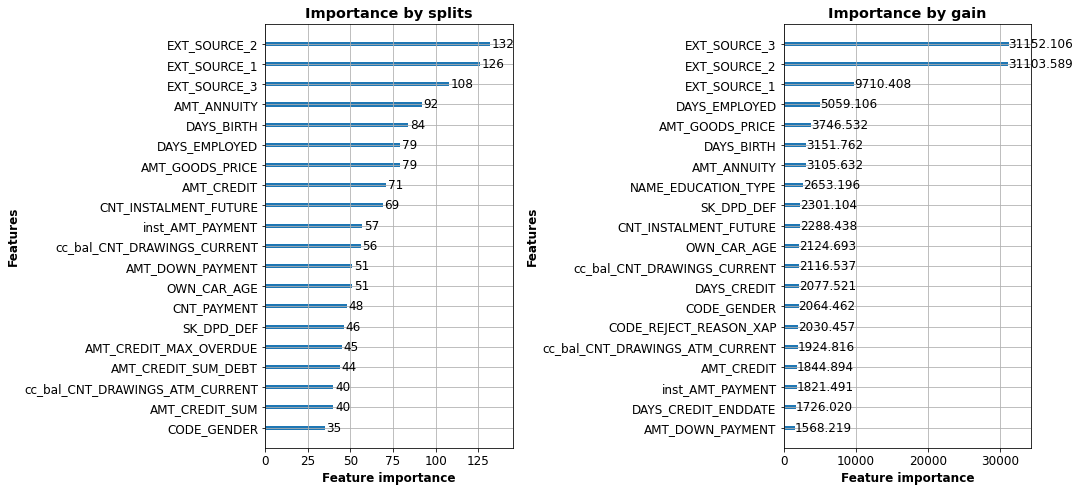

In [75]:
%%time
evals_result = {}
""" Predict on test set and create submission """
clf = lgbm.train(train_set=lgbm_train,
                 params=lgbm_params,
#                  valid_sets=[lgbm_train, lgbm_valid],
#                  evals_result=evals_result,
#                  verbose_eval=50,
                  feval=eval_fonct,
                 num_boost_round=optimum_boost_rounds)
clf.params['objective'] = 'probability'
contrib = clf.predict(X_test, pred_contrib =True)
y_pred = clf.predict(X_test)
# out_df = pd.DataFrame({'SK_ID_CURR': meta_df['SK_ID_CURR'][len_train:], 'TARGET': y_pred})
# out_df.to_csv('submission.csv', index=False)

fig, (ax, ax1) = plt.subplots(1, 2, figsize=[15, 7])
# doc sur les paramètres de lgbm.plot_importance
# importance_type (string, optional (default="split")) – How the importance is calculated. 
# If “split”, result contains numbers of times the feature is used in a model. 
# If “gain”, result contains total gains of splits which use the feature.
lgbm.plot_importance(clf, ax=ax, max_num_features=20, importance_type='split')
lgbm.plot_importance(clf, ax=ax1, max_num_features=20, importance_type='gain')
ax.set_title('Importance by splits')
ax1.set_title('Importance by gain')
plt.tight_layout()
# plt.savefig('feature_importance.png')

In [76]:
clf.params

{'boosting': 'dart',
 'application': 'binary',
 'learning_rate': 0.1,
 'min_data_in_leaf': 30,
 'num_leaves': 31,
 'max_depth': -1,
 'feature_fraction': 0.5,
 'scale_pos_weight': 1.4,
 'drop_rate': 0.025,
 'reg_lambda': 14,
 'sigmoid': 0.3,
 'objective': 'probability'}

In [77]:
# clf.params['objective'] = 'binary'
# clf.params['objective'] = 'probability'

# https://github.com/slundberg/shap/issues/1042
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test)


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


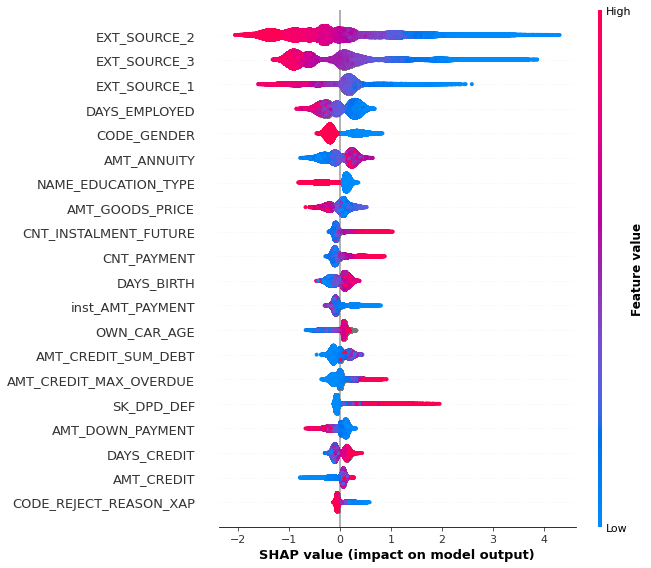

In [78]:
shap.summary_plot(shap_values, X_test)

In [79]:
len(shap_values)

101479

In [80]:
base = explainer.expected_value
base

-6.421390798775233

In [81]:
1/(1+np.exp(-base))

0.0016237518180690674

In [82]:
np.log(y_test.sum()/(len(y_test)-y_test.sum()))

-2.442523782420533

In [83]:
np.log(y_train.sum()/(len(y_train)-y_train.sum()))

-2.4275721864283883

In [84]:
df_homecredit[df_homecredit["Row"]=="AMT_ANNUITY"]

,Unnamed: 0,Table,Row,Description,Special
9,12,application_{train|test}.csv,AMT_ANNUITY,Loan annuity,NaN
138,141,bureau.csv,AMT_ANNUITY,Annuity of the Credit Bureau credit,NaN
176,179,previous_application.csv,AMT_ANNUITY,Annuity of previous application,NaN


In [85]:
df_application_train.loc[df_application_train["TARGET"]==1, "AMT_ANNUITY"].mean()

26481.744290030212

In [86]:
df_application_train.loc[df_application_train["TARGET"]==0, "AMT_ANNUITY"].mean()

27163.62334880463

In [87]:
help(shap.summary_plot)

Help on function summary_plot in module shap.plots.summary:

summary_plot(shap_values, features=None, feature_names=None, max_display=None, plot_type=None, color=None, axis_color='#333333', title=None, alpha=1, show=True, sort=True, color_bar=True, plot_size='auto', layered_violin_max_num_bins=20, class_names=None, class_inds=None, color_bar_label='Feature value', auto_size_plot=None)
    Create a SHAP summary plot, colored by feature values when they are provided.
    
    Parameters
    ----------
    shap_values : numpy.array
        For single output explanations this is a matrix of SHAP values (# samples x # features).
        For multi-output explanations this is a list of such matrices of SHAP values.
    
    features : numpy.array or pandas.DataFrame or list
        Matrix of feature values (# samples x # features) or a feature_names list as shorthand
    
    feature_names : list
        Names of the features (length # features)
    
    max_display : int
        How many top

infos sur l'utilisation de predict avec pred_contrib=True :  
https://github.com/microsoft/LightGBM/issues/1969

outil pour l'interprétation : SHAP  
https://github.com/slundberg/shap

In [88]:
y_pred.shape

(101479,)

In [89]:
contrib.shape

(101479, 375)

In [90]:
y_pred.mean()

0.15202870701885446

In [91]:
contrib[:,:-1].mean()

-8.281035521071049e-06

In [92]:
np.unique(contrib[:,-1])

array([-6.4213908])

In [93]:
y_pred[:10]

array([0.33991316, 0.09831474, 0.25190401, 0.06583667, 0.09325772,
       0.29130886, 0.0830459 , 0.26868825, 0.15100539, 0.09742866])

In [94]:
data.shape

(307511, 374)

## Calcul du seuil


Nous travaillons pour un organisme de crédit. Nous voulons donc minimiser le risque que le crédit ne soit pas remboursé. Nous voulons donc minimiser le nombre de faux négatifs, c'est à dire les personnes auxquelles on accorderait un crédit et qui ne seraient pas en mesure de le rembourser.    

Calculons le seuil correspondant à un taux de faux négatifs (FN/(FN+TP))choisi.  
Pour avoir un taux de faux négatifs < 5%, il faut un taux de vrai positifs (TP/(FN+TP))>95%.

In [95]:
if eval_fonct_str=="eval_auc":
    fpr, tpr, th = roc_curve(y_test, y_pred)
    fn_max = 0.05
    idx = np.min(np.where(tpr>(1-fn_max)))
#     print(f"Pour un taux de faux négatif de {fn_max*100}%, ")
#     print(f"le taux de faux positifs est de {fpr[idx]*100:.1f}%,")
#     print(f"et le seuil est de {th[idx]*100:.1f}%")
    seuil = th[idx]
    print("seuil : ", seuil)
    conf_matrix(y_test, y_pred, seuil)
elif eval_fonct_str =="eval_average_precision":
    prec, rec, th = precision_recall_curve(y_test, y_pred)
    fn_max = 0.15
    idx = np.max(np.where(rec>(1-fn_max)))
    seuil = th[idx]
    print("seuil : ", seuil)
    conf_matrix(y_test, y_pred, seuil)
elif eval_fonct_str in ["eval_Kulczynski_mod"]:
    thresholds = np.arange(0,1, 0.01)
    scores = [eval_fonct_score(y_test, y_pred, t, eval_fonct_param1) for t in thresholds]
    idx = np.argmax(scores[1:])
    score  = scores[idx]
    seuil = thresholds[idx]
    print("seuil : ", seuil)
    print("score : ", score)
    conf_matrix(y_test, y_pred, seuil)
elif eval_fonct_str == "eval_perso1":
    thresholds = np.arange(0,1, 0.01)
    scores = [eval_fonct_score(y_test, y_pred, t, eval_fonct_param1, eval_fonct_param2) for t in thresholds]
    idx = np.argmax(scores[1:])
    score  = scores[idx]
    seuil = thresholds[idx]
    print("seuil : ", seuil)
    print("score : ", score)
    conf_matrix(y_test, y_pred, seuil)
elif eval_fonct_str == "eval_tanimoto_mod":
    thresholds = np.arange(0,1, 0.01)
    scores = [eval_fonct_score(y_test, y_pred, t) for t in thresholds]
    idx = np.argmax(scores[1:])
    score  = scores[idx]
    seuil = thresholds[idx]
    print("seuil : ", seuil)
    print("score : ", score)
    conf_matrix(y_test, y_pred, seuil)
elif eval_fonct_str == "fbeta_eval3":
    thresholds = np.arange(0,1, 0.01)
    scores = [eval_fonct_score(y_test, to_labels(y_pred, t), eval_fonct_param1) for t in thresholds]
    idx = np.argmax(scores[1:])
    score  = scores[idx]
    seuil = thresholds[idx]
    print("seuil : ", seuil)
    print("score : ", score)
    conf_matrix(y_test, y_pred, seuil)
   

seuil :  0.11271111677576319
tp :  6900
tn :  47308
fp :  46054
fn :  1217
fpr = 49.33%
fnr = 14.99%
precision = 13.03%
recall = 85.01%


In [96]:
# pd.Series(y_pred).to_csv("y_pred_fbeta3_95.csv", index = False)

**fbeta_score, beta=4**  
tp :  7898  
tn :  16390  
fp :  76972  
fn :  219  
fpr = 82.44%  
fnr = 2.70%  
precision = 9.31%  
recall = 97.30%  

**fbeta_score, beta=3.8**  
seuil :  0.05  
score :  0.6207372298025252  
tp :  7602  
tn :  29084  
fp :  64278  
fn :  515  
fpr = 68.85%  
fnr = 6.34%  
precision = 10.58%  
recall = 93.66%  

**fbeta_score, beta=3.6**  
seuil :  0.06  
score :  0.6108316344692227  
tp :  7331  
tn :  38346  
fp :  55016  
fn :  786  
fpr = 58.93%  
fnr = 9.68%  
precision = 11.76%  
recall = 90.32%  

**fbeta_score, beta=3**   
tp :  6876  
tn :  48479  
fp :  44883  
fn :  1241  
fpr = 48.07%  
fnr = 15.29%  
precision = 13.28%  
recall = 84.71%  

**fbeta_score, beta=3, 1000 rounds**   
seuil :  0.07  
score :  0.557031555613509  
tp :  6835  
tn :  50546  
fp :  42816  
fn :  1282  
fpr = 45.86%  
fnr = 15.79%  
precision = 13.77%  
recall = 84.21%  

**fbeta_score, beta = 2**    
tp :  5502  
tn :  68102  
fp :  25260  
fn :  2615  
fpr = 27.06%  
fnr = 32.22%  
precision = 17.89%  
recall = 67.78%  

**AUC**    
tp : 7712  
tn : 27154  
fp : 66208  
fn : 405  
fpr : 0.7091536171033183  
fnr : 0.04989528150794629  
precision : 0.10432900432900433  
recall : 0.9501047184920537  


**average_precision**  
seuil :  0.07509545445933284  
tp :  7712  
tn :  25559  
fp :  67803  
fn :  405  
fpr = 72.62%  
fnr = 4.99%  
precision = 10.21%  
recall = 95.01%   

**balanced_accuracy_score**    
tp :  5374  
tn :  69599  
fp :  23763  
fn :  2743  
fpr = 25.45%  
fnr = 33.79%  
precision = 18.44%  
recall = 66.21%  

**Matthews**  
tp :  5146  
tn :  71592  
fp :  21770  
fn :  2971  
fpr = 23.32%  
fnr = 36.60%  
precision = 19.12%  
recall = 63.40%  

**tanimoto_mod**    
seuil :  0.41000000000000003  
score :  0.750621228257011  
tp :  1103  
tn :  91935  
fp :  1427  
fn :  7014  
fpr = 1.53%  
fnr = 86.41%  
precision = 43.60%  
recall = 13.59%  

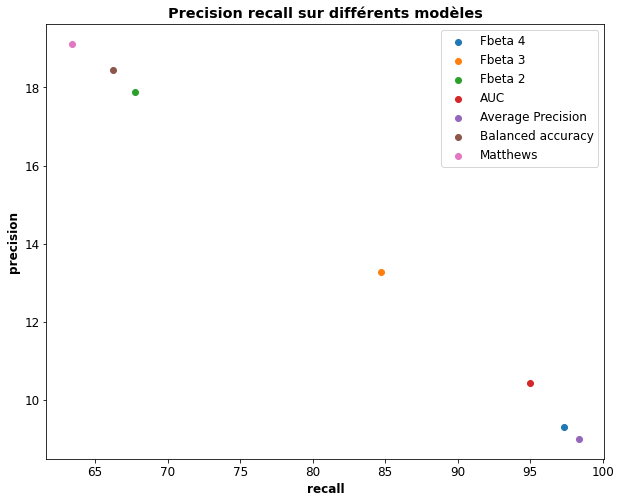

In [97]:
plt.scatter(y=9.31, x=97.3, label="Fbeta 4")
plt.scatter(y=13.28, x=84.71, label="Fbeta 3")
plt.scatter(y=17.89, x=67.78, label="Fbeta 2")
plt.scatter(y=10.43, x=95, label="AUC")
plt.scatter(y=9, x=98.36, label="Average Precision")
plt.scatter(y=18.44, x=66.21, label="Balanced accuracy")
plt.scatter(y=19.12, x=63.40, label="Matthews")
plt.legend()
plt.title("Precision recall sur différents modèles")
plt.xlabel("recall")
plt.ylabel("precision")
plt.show()


In [98]:
# prec, rec, th = precision_recall_curve(y_test, y_pred)
# plt.plot(rec, prec)
# plt.xlabel("recall")
# plt.ylabel("precision")
# plt.title("optimisation de Average Precision")
# plt.show()

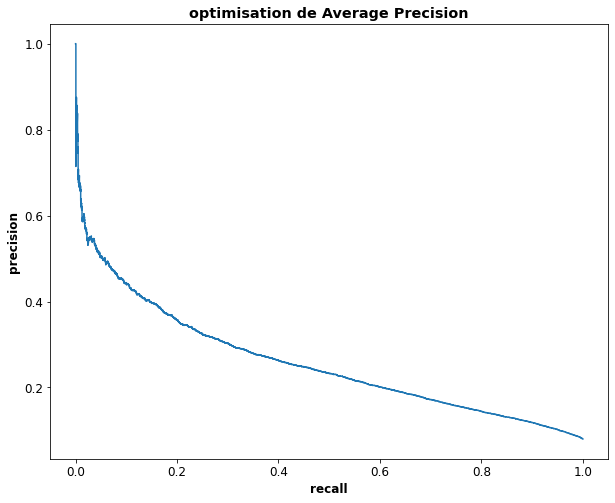

# Explicabilité

## Préparation des données

Nous reprenons le modèle qui a déjà été entraîné (sur le jeu d'entraînement) et nous l'utilisons maintenant pour prédire la totalité des données.  

In [99]:
y_pred = clf.predict(data)
contrib = clf.predict(data, pred_contrib =True)
y_pred

array([0.49419305, 0.06397794, 0.07061812, ..., 0.14731532, 0.09573594,
       0.18675601])

In [100]:
contrib[:, -1]

array([-6.4213908, -6.4213908, -6.4213908, ..., -6.4213908, -6.4213908,
       -6.4213908])

In [101]:
y_pred

array([0.49419305, 0.06397794, 0.07061812, ..., 0.14731532, 0.09573594,
       0.18675601])

In [102]:
contrib

array([[ 2.10964406e-02,  2.12399191e-01,  4.09136248e-03, ...,
        -1.49330952e-02, -1.03248639e-01, -6.42139080e+00],
       [ 8.48906451e-03, -2.49623020e-01,  2.37115130e-02, ...,
        -6.34712662e-02, -1.33408152e-01, -6.42139080e+00],
       [-1.14390779e-01,  4.72012970e-01, -1.55191908e-02, ...,
         2.09125069e-02,  3.36201878e-02, -6.42139080e+00],
       ...,
       [ 1.41816708e-02, -1.65623342e-01,  1.75899574e-02, ...,
         1.26965174e-01,  3.50395899e-01, -6.42139080e+00],
       [ 7.08561891e-03, -2.47030283e-01,  1.61178511e-02, ...,
        -1.23018571e-02, -9.54819357e-03, -6.42139080e+00],
       [ 2.44016518e-02, -1.34578241e-01,  8.29752092e-03, ...,
        -5.47978993e-02, -8.54227723e-02, -6.42139080e+00]])

In [103]:
contrib

array([[ 2.10964406e-02,  2.12399191e-01,  4.09136248e-03, ...,
        -1.49330952e-02, -1.03248639e-01, -6.42139080e+00],
       [ 8.48906451e-03, -2.49623020e-01,  2.37115130e-02, ...,
        -6.34712662e-02, -1.33408152e-01, -6.42139080e+00],
       [-1.14390779e-01,  4.72012970e-01, -1.55191908e-02, ...,
         2.09125069e-02,  3.36201878e-02, -6.42139080e+00],
       ...,
       [ 1.41816708e-02, -1.65623342e-01,  1.75899574e-02, ...,
         1.26965174e-01,  3.50395899e-01, -6.42139080e+00],
       [ 7.08561891e-03, -2.47030283e-01,  1.61178511e-02, ...,
        -1.23018571e-02, -9.54819357e-03, -6.42139080e+00],
       [ 2.44016518e-02, -1.34578241e-01,  8.29752092e-03, ...,
        -5.47978993e-02, -8.54227723e-02, -6.42139080e+00]])

In [104]:
# fpr, tpr, th = roc_curve(y, y_pred[:,1])
# auc_test =  auc(fpr, tpr)
# auc_test

In [105]:
df_data_applicant = pd.concat([applicants, pd.Series(y_pred, name="score"), data], axis=1)
df_data_applicant

,SK_ID_CURR,score,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,cc_bal_cc_bal_status__Demand,cc_bal_cc_bal_status__Refused,cc_bal_cc_bal_status__Sent_proposal,cc_bal_cc_bal_status__Signed,inst_NUM_INSTALMENT_VERSION,inst_NUM_INSTALMENT_NUMBER,inst_DAYS_INSTALMENT,inst_DAYS_ENTRY_PAYMENT,inst_AMT_INSTALMENT,inst_AMT_PAYMENT
0,100002,0.494193,0,0,0,0,0,202500.0,406597.5,24700.5,...,NaN,NaN,NaN,NaN,1.052632,10.000000,-295.000000,-315.421053,11559.247105,11559.247105
1,100003,0.063978,0,1,0,1,0,270000.0,1293502.5,35698.5,...,NaN,NaN,NaN,NaN,1.040000,5.080000,-1378.160000,-1385.320000,64754.586000,64754.586000
2,100004,0.070618,1,0,1,0,0,67500.0,135000.0,6750.0,...,NaN,NaN,NaN,NaN,1.333333,2.000000,-754.000000,-761.666667,7096.155000,7096.155000
3,100006,0.071487,0,1,0,0,0,135000.0,312682.5,29686.5,...,0.0,0.0,0.0,0.0,1.125000,4.437500,-252.250000,-271.625000,62947.088438,62947.088438
4,100007,0.139781,0,0,0,0,0,121500.0,513000.0,21865.5,...,NaN,NaN,NaN,NaN,1.166667,7.045455,-1028.606061,-1032.242424,12666.444545,12214.060227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0.212502,0,0,0,1,0,157500.0,254700.0,27558.0,...,NaN,NaN,NaN,NaN,1.142857,4.000000,-120.000000,-156.285714,7492.924286,7492.924286
307507,456252,0.189225,0,1,0,0,0,72000.0,269550.0,12001.5,...,NaN,NaN,NaN,NaN,1.000000,3.500000,-2391.000000,-2393.833333,10069.867500,10069.867500
307508,456253,0.147315,0,1,0,0,0,153000.0,677664.0,29979.0,...,NaN,NaN,NaN,NaN,1.000000,4.785714,-2372.928571,-2387.428571,4399.707857,4115.915357
307509,456254,0.095736,0,1,0,0,0,171000.0,370107.0,20205.0,...,NaN,NaN,NaN,NaN,1.000000,5.263158,-142.263158,-161.263158,10239.832895,10239.832895


In [106]:
feature_gain = pd.concat([pd.Series(clf.feature_name(), name="feature"),
    pd.Series(clf.feature_importance(importance_type='gain'), name="gain")], axis=1)
feature_gain.sort_values(by="gain", ascending=False).head(20)

,feature,gain
41,EXT_SOURCE_3,31152.105773
40,EXT_SOURCE_2,31103.589093
39,EXT_SOURCE_1,9710.408404
16,DAYS_EMPLOYED,5059.105558
8,AMT_GOODS_PRICE,3746.531897
15,DAYS_BIRTH,3151.761543
7,AMT_ANNUITY,3105.632273
11,NAME_EDUCATION_TYPE,2653.195799
331,SK_DPD_DEF,2301.103501
329,CNT_INSTALMENT_FUTURE,2288.438483


In [107]:
(feature_gain["gain"]==0.).sum()

133

## Données pour l'explicabilité

In [108]:
#clf.params['objective'] = 'probability'
# https://github.com/slundberg/shap/issues/1042

explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(data)


In [109]:
help(explainer.shap_values)

Help on method shap_values in module shap.explainers.tree:

shap_values(X, y=None, tree_limit=None, approximate=False, check_additivity=True) method of shap.explainers.tree.TreeExplainer instance
    Estimate the SHAP values for a set of samples.
    
    Parameters
    ----------
    X : numpy.array, pandas.DataFrame or catboost.Pool (for catboost)
        A matrix of samples (# samples x # features) on which to explain the model's output.
    
    y : numpy.array
        An array of label values for each sample. Used when explaining loss functions.
    
    tree_limit : None (default) or int
        Limit the number of trees used by the model. By default None means no use the limit of the
        original model, and -1 means no limit.
    
    approximate : bool
        Run fast, but only roughly approximate the Tree SHAP values. This runs a method
        previously proposed by Saabas which only considers a single feature ordering. Take care
        since this does not have the cons

In [110]:
help(explainer)

Help on TreeExplainer in module shap.explainers.tree object:

class TreeExplainer(shap.explainers.explainer.Explainer)
 |  TreeExplainer(model, data=None, model_output='raw', feature_perturbation='interventional', **deprecated_options)
 |  
 |  Uses Tree SHAP algorithms to explain the output of ensemble tree models.
 |  
 |  Tree SHAP is a fast and exact method to estimate SHAP values for tree models and ensembles of trees,
 |  under several different possible assumptions about feature dependence. It depends on fast C++
 |  implementations either inside an externel model package or in the local compiled C extention.
 |  
 |  Parameters
 |  ----------
 |  model : model object
 |      The tree based machine learning model that we want to explain. XGBoost, LightGBM, CatBoost, Pyspark
 |      and most tree-based scikit-learn models are supported.
 |  
 |  data : numpy.array or pandas.DataFrame
 |      The background dataset to use for integrating out features. This argument is optional whe

In [111]:
shap_values

array([[ 0.02109644,  0.21239919,  0.00409136, ..., -0.01495321,
        -0.0149331 , -0.10324864],
       [ 0.00848906, -0.24962302,  0.02371151, ..., -0.00643534,
        -0.06347127, -0.13340815],
       [-0.11439078,  0.47201297, -0.01551919, ..., -0.01088111,
         0.02091251,  0.03362019],
       ...,
       [ 0.01418167, -0.16562334,  0.01758996, ..., -0.00910196,
         0.12696517,  0.3503959 ],
       [ 0.00708562, -0.24703028,  0.01611785, ...,  0.06764691,
        -0.01230186, -0.00954819],
       [ 0.02440165, -0.13457824,  0.00829752, ..., -0.00205581,
        -0.0547979 , -0.08542277]])

In [112]:
explainer.expected_value

-6.421390798775233

In [113]:
odds_train = (y_train==1).sum()/(y_train==0).sum()
odds_train

0.08825082926623143

In [114]:
np.log(odds_train)

-2.4275721864283883

In [115]:
np.log(np.mean(y_train))

-2.512143849896499

In [116]:
shap_values.sum()

-314.29135014382604

In [117]:
np.exp(explainer.expected_value)

0.001626392676133834

In [118]:
odds = np.exp(-explainer.expected_value)
odds

614.8576630196969

expected_value (base value) est le logarithme de la cote (?? odds) de chaque classe. p(0)/p(1).  
Comme p(0) > p(1), p(0)/p(1) > 1 et ln(p(0)/p(1))>0.  
De même p(1)/p(0) < 1 et ln( p(1)/p(0 ) <0.

In [119]:
np.log(y_train.sum()/len(y_train))

-2.512143849896499

In [120]:
np.log(y_train.sum()/(len(y_train)-y_train.sum()))

-2.4275721864283883

In [121]:
np.sum(contrib[:,:-1])

-314.29135014382604

In [122]:
np.log((y_train==1).sum()/(y_train==0).sum()*100)

2.177597999559703

In [123]:
y_pred.mean()

0.1521824162603258

## Analyse d'une demande

In [124]:
np.random.seed(42)

In [174]:
this_client = np.random.randint(0, len(y))
this_client

131932

### Description du client

In [175]:
no_client = df_data_applicant.loc[this_client, "SK_ID_CURR"]
print("numéro de client : ", no_client)
genre = df_data_applicant.loc[this_client, "CODE_GENDER"]
if genre==0:
    print("genre : masculin")
else :
    print("genre : féminin")
age_jours = df_data_applicant.loc[this_client, "DAYS_BIRTH"]
print(f"âge : {-age_jours/365:.0f} ans")

numéro de client :  253016
genre : masculin
âge : 39 ans


In [176]:
df_homecredit[df_homecredit["Row"]=="CNT_INSTALMENT"]

,Unnamed: 0,Table,Row,Description,Special
145,148,POS_CASH_balance.csv,CNT_INSTALMENT,Term of previous credit (can change over time),NaN


In [177]:
list(df_homecredit[df_homecredit["Row"]=="AMT_GOODS_PRICE"]["Description"])

['For consumer loans it is the price of the goods for which the loan is given',
 'Goods price of good that client asked for (if applicable) on the previous application']

In [178]:
# df_application_train["AMT_ANNUITY"].describe()
df_pos_cash_balance["CNT_INSTALMENT_FUTURE"].describe()

count    9.975271e+06
mean     1.048384e+01
std      1.110906e+01
min      0.000000e+00
25%      3.000000e+00
50%      7.000000e+00
75%      1.400000e+01
max      8.500000e+01
Name: CNT_INSTALMENT_FUTURE, dtype: float64

In [179]:
df_prev_app.columns

Index(['SK_ID_PREV', 'SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'AMT_ANNUITY',
       'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_DOWN_PAYMENT', 'AMT_GOODS_PRICE',
       'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START',
       'FLAG_LAST_APPL_PER_CONTRACT', 'NFLAG_LAST_APPL_IN_DAY',
       'RATE_DOWN_PAYMENT', 'RATE_INTEREST_PRIMARY',
       'RATE_INTEREST_PRIVILEGED', 'NAME_CASH_LOAN_PURPOSE',
       'NAME_CONTRACT_STATUS', 'DAYS_DECISION', 'NAME_PAYMENT_TYPE',
       'CODE_REJECT_REASON', 'NAME_TYPE_SUITE', 'NAME_CLIENT_TYPE',
       'NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE',
       'CHANNEL_TYPE', 'SELLERPLACE_AREA', 'NAME_SELLER_INDUSTRY',
       'CNT_PAYMENT', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION',
       'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION',
       'DAYS_LAST_DUE', 'DAYS_TERMINATION', 'NFLAG_INSURED_ON_APPROVAL'],
      dtype='object')

### Score et interprétation

In [180]:
score = df_data_applicant.loc[this_client, "score"]
print("Score : " + f"{score*100:.1f} %")
if score < seuil :
    print("==> pas de risque particulier")
else :
    print("==> client à risque")
score_ext_1, score_ext_2, score_ext_3 = df_data_applicant.loc[this_client, ["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]]
print(f"Scores externes : score 1 : {score_ext_1*100:.0f}%, score 2 : {score_ext_2*100:.0f}%, score 3 : {score_ext_3*100:.0f}%")
annuity = df_data_applicant.loc[this_client, "AMT_ANNUITY"]
print(f"Montant de l'annuité : {annuity:.2f}")
goods_price = df_data_applicant.loc[this_client, "AMT_GOODS_PRICE"]
print(f"Prix du bien acheté : {goods_price}")
installment_prev_credit = df_data_applicant.loc[this_client, "CNT_INSTALMENT_FUTURE"]
print(f"Nombre de versements restants de précédents crédits : {installment_prev_credit}")

Score : 5.7 %
==> pas de risque particulier
Scores externes : score 1 : 31%, score 2 : 61%, score 3 : 55%
Montant de l'annuité : 33025.50
Prix du bien acheté : 1125000.0
Nombre de versements restants de précédents crédits : 6.5625


In [181]:
clf.predict(df_data_applicant.iloc[this_client, 2:])

Converting data to scipy sparse matrix.


array([0.05720851])

In [182]:
df_data_applicant.iloc[this_client, :]

SK_ID_CURR                    253016.000000
score                              0.057209
NAME_CONTRACT_TYPE                 0.000000
CODE_GENDER                        0.000000
FLAG_OWN_CAR                       1.000000
                                  ...      
inst_NUM_INSTALMENT_NUMBER         4.812500
inst_DAYS_INSTALMENT           -1486.625000
inst_DAYS_ENTRY_PAYMENT        -1501.250000
inst_AMT_INSTALMENT            17822.370937
inst_AMT_PAYMENT               16848.531563
Name: 131932, Length: 376, dtype: float64

In [183]:
contrib[:,-1]

array([-6.4213908, -6.4213908, -6.4213908, ..., -6.4213908, -6.4213908,
       -6.4213908])

In [184]:
contrib[:,:-1].sum()

-314.29135014382604

In [185]:
np.log(0.21)

-1.5606477482646683

In [186]:
np.log(0.08/0.92)

-2.4423470353692043

In [187]:
np.where(data.columns=="CODE_GENDER")

(array([1], dtype=int64),)

In [188]:
y_train.mean()

0.08109419895938495

In [189]:
data.iloc[this_client,:]

NAME_CONTRACT_TYPE                0.000000
CODE_GENDER                       0.000000
FLAG_OWN_CAR                      1.000000
FLAG_OWN_REALTY                   0.000000
CNT_CHILDREN                      0.000000
                                  ...     
inst_NUM_INSTALMENT_NUMBER        4.812500
inst_DAYS_INSTALMENT          -1486.625000
inst_DAYS_ENTRY_PAYMENT       -1501.250000
inst_AMT_INSTALMENT           17822.370937
inst_AMT_PAYMENT              16848.531563
Name: 131932, Length: 374, dtype: float64

In [190]:
len(shap_values[this_client,:])

374

In [191]:
1/(1+np.exp(-0.081))

0.5202389355718147

In [192]:
p=0.081
np.log(p/(1-p))

-2.428836967683248

In [193]:
np.log(p)

-2.513306124309698

In [194]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[this_client,:], data.iloc[this_client,:])
# shap.force_plot(explainer.expected_value[1], shap_values[1][this_client,:], data.iloc[this_client,:], link="logit")
# shap.visualize(shap_values[this_client,:], data.iloc[this_client,:], link=shap.LogitLink())

In [195]:
shap_values[this_client,:].sum()+explainer.expected_value

-9.34047521328989

On a donc,  (somme des shap values de l'individu) + (base value) = model output value  
soit (somme des contributions des features) + (valeur de base) = valeur de l'individu

In [196]:
explainer.expected_value

-6.421390798775233

In [197]:
df_shap_values = pd.DataFrame(data=shap_values, columns = data.columns)

In [198]:
df_shap_values.iloc[this_client, :].sort_values()

EXT_SOURCE_3                -0.504367
DAYS_EMPLOYED               -0.377581
NAME_EDUCATION_TYPE         -0.341823
OWN_CAR_AGE                 -0.301936
EXT_SOURCE_2                -0.285333
                               ...   
NAME_PRODUCT_TYPE_walk_in    0.088110
CODE_GENDER                  0.204084
AMT_CREDIT_SUM_DEBT          0.215985
AMT_ANNUITY                  0.218517
EXT_SOURCE_1                 0.317313
Name: 131932, Length: 374, dtype: float64

In [199]:
df_data_applicant.loc[this_client, "NAME_EDUCATION_TYPE"]

1

In [200]:
df_homecredit[df_homecredit["Row"]=="NAME_EDUCATION_TYPE"]

,Unnamed: 0,Table,Row,Description,Special
13,16,application_{train|test}.csv,NAME_EDUCATION_TYPE,Level of highest education the client achieved,NaN


In [201]:
help(shap.force_plot)

Help on function force_plot in module shap.plots.force:

force_plot(base_value, shap_values, features=None, feature_names=None, out_names=None, link='identity', plot_cmap='RdBu', matplotlib=False, show=True, figsize=(20, 3), ordering_keys=None, ordering_keys_time_format=None, text_rotation=0)
    Visualize the given SHAP values with an additive force layout.
    
    Parameters
    ----------
    base_value : float
        This is the reference value that the feature contributions start from. For SHAP values it should
        be the value of explainer.expected_value.
    
    shap_values : numpy.array
        Matrix of SHAP values (# features) or (# samples x # features). If this is a 1D array then a single
        force plot will be drawn, if it is a 2D array then a stacked force plot will be drawn.
    
    features : numpy.array
        Matrix of feature values (# features) or (# samples x # features). This provides the values of all the
        features, and should be the same shap

In [202]:
shap.force_plot(explainer.expected_value, shap_values[this_client,:], data.iloc[this_client,:], link="logit")


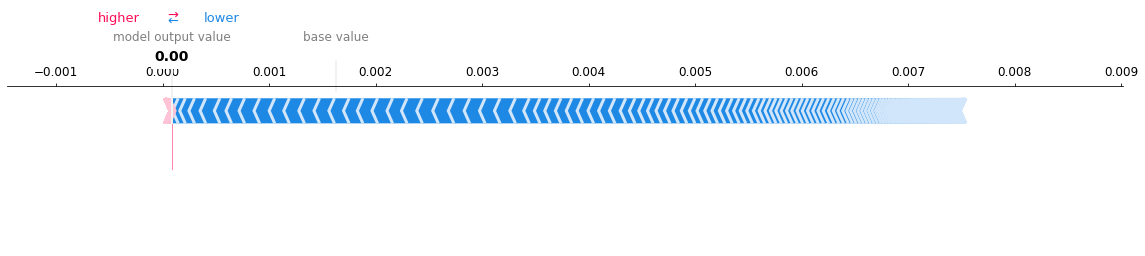

In [203]:
shap.force_plot(explainer.expected_value, shap_values[this_client,:], data.iloc[this_client,:], link="logit", matplotlib=True)

In [204]:
np.log(0.01/0.99)

-4.59511985013459

In [205]:
df_shap_values.iloc[this_client, :].sum()

-2.919084414514657

In [206]:
df_shap_values.shape

(307511, 374)

In [207]:
df_data_applicant.iloc[this_client,:]

SK_ID_CURR                    253016.000000
score                              0.057209
NAME_CONTRACT_TYPE                 0.000000
CODE_GENDER                        0.000000
FLAG_OWN_CAR                       1.000000
                                  ...      
inst_NUM_INSTALMENT_NUMBER         4.812500
inst_DAYS_INSTALMENT           -1486.625000
inst_DAYS_ENTRY_PAYMENT        -1501.250000
inst_AMT_INSTALMENT            17822.370937
inst_AMT_PAYMENT               16848.531563
Name: 131932, Length: 376, dtype: float64

In [208]:
# https://www.kaggle.com/dansbecker/shap-values
# https://towardsdatascience.com/one-feature-attribution-method-to-supposedly-rule-them-all-shapley-values-f3e04534983d
# https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d

### Comparaison à des clients semblables

In [209]:
facteurs_favorables = df_shap_values.iloc[this_client, :].sort_values().head().keys()
facteurs_favorables

Index(['EXT_SOURCE_3', 'DAYS_EMPLOYED', 'NAME_EDUCATION_TYPE', 'OWN_CAR_AGE',
       'EXT_SOURCE_2'],
      dtype='object')

In [210]:
facteurs_risque = df_shap_values.iloc[this_client, :].sort_values().tail().keys()
facteurs_risque

Index(['NAME_PRODUCT_TYPE_walk_in', 'CODE_GENDER', 'AMT_CREDIT_SUM_DEBT',
       'AMT_ANNUITY', 'EXT_SOURCE_1'],
      dtype='object')

In [211]:
print("Facteurs favorables : ")
for f in facteurs_favorables :
    print(f, df_data_applicant.loc[this_client, f])

print("\nFacteurs de risque : ")
for f in facteurs_risque :
    print(f, df_data_applicant.loc[this_client, f])

Facteurs facvorables : 
EXT_SOURCE_3 0.5549467685334323
DAYS_EMPLOYED 5929.0
NAME_EDUCATION_TYPE 1
OWN_CAR_AGE 1.0
EXT_SOURCE_2 0.6084269866658087

Facteurs de risque : 
NAME_PRODUCT_TYPE_walk_in 0.25
CODE_GENDER 0
AMT_CREDIT_SUM_DEBT 829296.6923076923
AMT_ANNUITY 33025.5
EXT_SOURCE_1 0.3059186373206432


Facteurs favorables : 


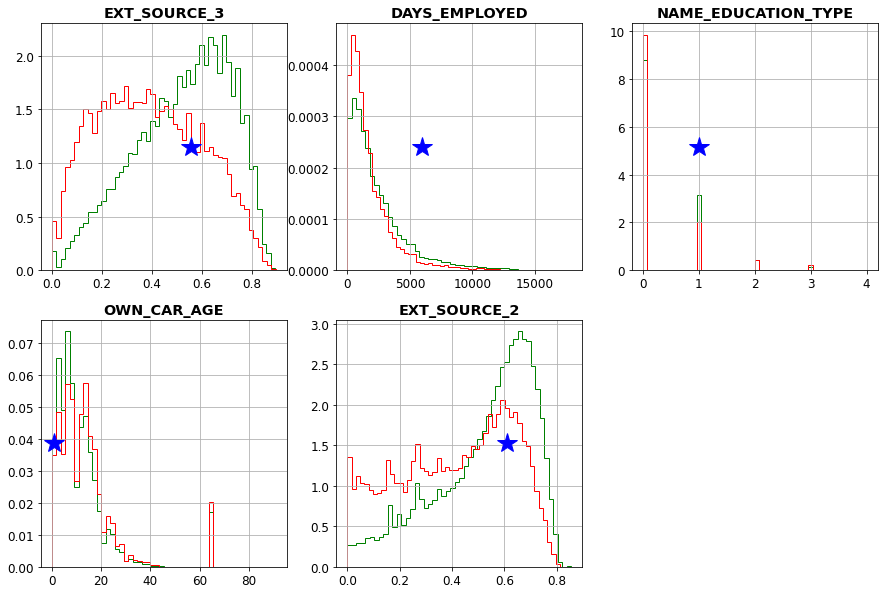


Facteurs de risque : 


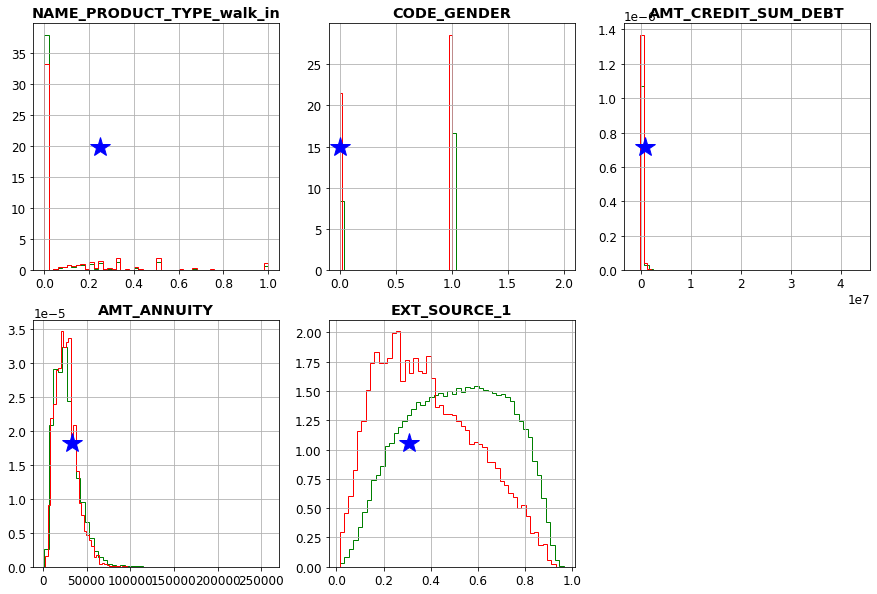

In [212]:
print("Facteurs favorables : ")
plt.figure(figsize=(15,10))
for i, f in enumerate(facteurs_favorables) :
    plt.subplot(2,3, i +1)
#     print(f, df_data_applicant.loc[this_client, f])
# #     print(f, df_data_true.loc[df_data_true["risk"]==0, f].mean())
#     print(f, df_data_true.loc[df_data_true["risk"]==0, f].quantile(0.25))
#     print(f, df_data_true.loc[df_data_true["risk"]==0, f].quantile(0.75))
    nf = df_data_true.loc[df_data_true["risk"]==0, f].hist(density=True, bins=50, histtype='step', color="green")
    nr = df_data_true.loc[df_data_true["risk"]==1, f].hist(density=True, bins=50, histtype='step', color="red")
    y_plot = max(nf.get_ylim()[1], nr.get_ylim()[1])/2
    plt.plot(df_data_applicant.loc[this_client, f], y_plot, color="blue", marker="*", markersize=20)    
    plt.title(f)
plt.show()
    
    
print("\nFacteurs de risque : ")
plt.figure(figsize=(15,10))
for i, f in enumerate(facteurs_risque) :
    plt.subplot(2,3, i +1)
#     print(f, df_data_applicant.loc[this_client, f])
# #     print(f, df_data_true.loc[df_data_true["risk"]==0, f].mean())
#     print(f, df_data_true.loc[df_data_true["risk"]==0, f].quantile(0.25))
#     print(f, df_data_true.loc[df_data_true["risk"]==0, f].quantile(0.75))
    nf = df_data_true.loc[df_data_true["risk"]==0, f].hist(density=True, bins=50, histtype='step', color="green")
    nr = df_data_true.loc[df_data_true["risk"]==1, f].hist(density=True, bins=50, histtype='step', color="red")
    y_plot = max(nf.get_ylim()[1], nr.get_ylim()[1])/2
    plt.plot(df_data_applicant.loc[this_client, f], y_plot, color="blue", marker="*", markersize=20)    
    plt.title(f)

plt.show()


In [213]:
seuil

0.11271111677576319

Facteurs favorables : 


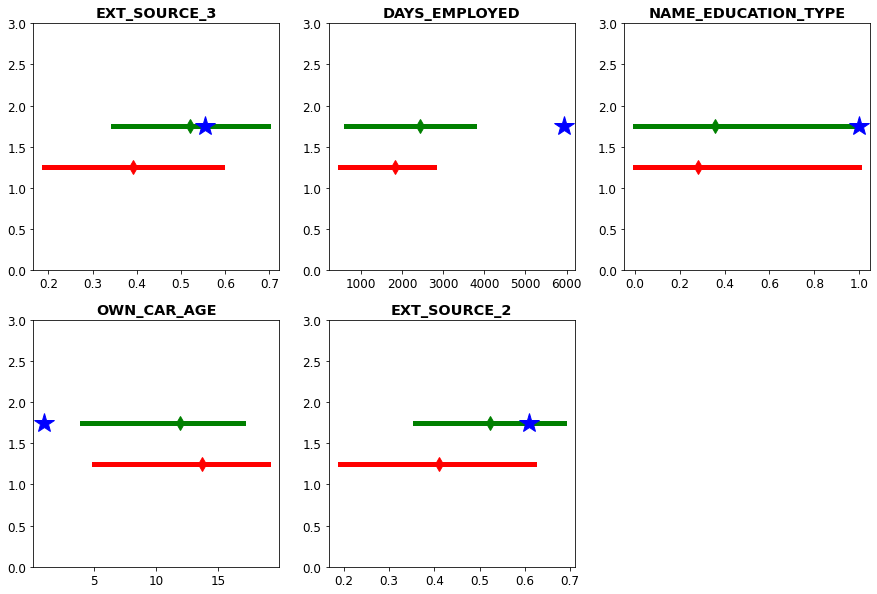


Facteurs de risque : 


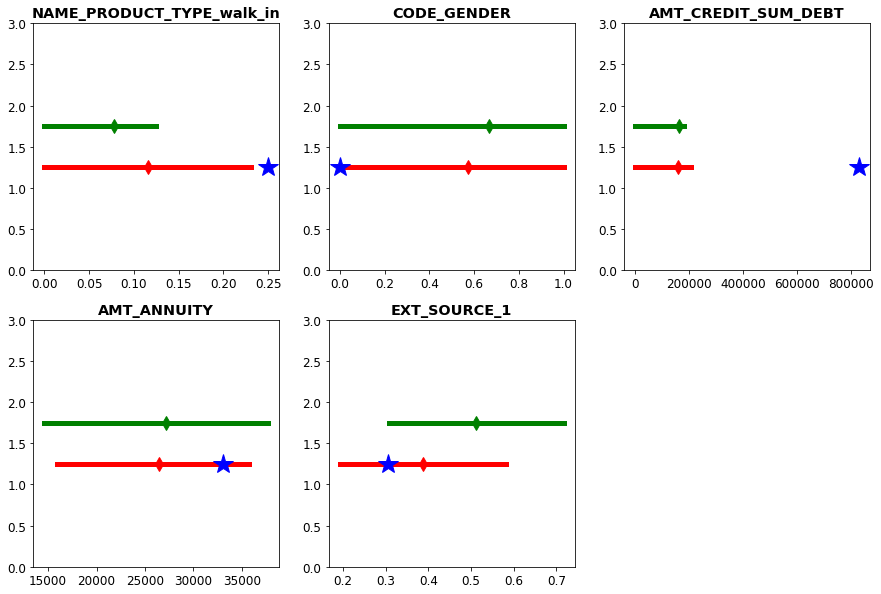

In [214]:
yplot_risque = 1.25
yplot_favorable = 1.75
# if score < seuil:
#     this_client_yplot = yplot_favorable
# else :
#     this_client_yplot = yplot_risque

    
print("Facteurs favorables : ")
plt.figure(figsize=(15,10))
for i, f in enumerate(facteurs_favorables) :
    ax = plt.subplot(2,3, i +1)
    qf10 = df_data_true.loc[df_data_true["risk"]==0, f].quantile(0.2)
    qf90 = df_data_true.loc[df_data_true["risk"]==0, f].quantile(0.8)
    fm = df_data_true.loc[df_data_true["risk"]==0, f].mean()
    qr10 = df_data_true.loc[df_data_true["risk"]==1, f].quantile(0.2)
    qr90 = df_data_true.loc[df_data_true["risk"]==1, f].quantile(0.8)
    rm = df_data_true.loc[df_data_true["risk"]==1, f].mean()
    plt.plot((qf10, qf90), (yplot_favorable,yplot_favorable), linewidth=5, color="green")
    plt.plot(fm, yplot_favorable, color="green", marker="d", markersize=10)    
    plt.plot((qr10, qr90), (yplot_risque,yplot_risque), linewidth=5, color="red")
    plt.plot(rm, yplot_risque, color="red", marker="d", markersize=10)    
    plt.plot(df_data_applicant.loc[this_client, f], yplot_favorable, color="blue", marker="*", markersize=20)    
    ax.set_ylim(0,3)
    plt.title(f)
plt.show()
    
    
print("\nFacteurs de risque : ")
plt.figure(figsize=(15,10))
for i, f in enumerate(facteurs_risque) :
    ax = plt.subplot(2,3, i +1)
    qf10 = df_data_true.loc[df_data_true["risk"]==0, f].quantile(0.2)
    qf90 = df_data_true.loc[df_data_true["risk"]==0, f].quantile(0.8)
    fm = df_data_true.loc[df_data_true["risk"]==0, f].mean()
    qr10 = df_data_true.loc[df_data_true["risk"]==1, f].quantile(0.2)
    qr90 = df_data_true.loc[df_data_true["risk"]==1, f].quantile(0.8)
    rm = df_data_true.loc[df_data_true["risk"]==1, f].mean()
    plt.plot((qf10, qf90), (yplot_favorable,yplot_favorable), linewidth=5, color="green")
    plt.plot(fm, yplot_favorable, color="green", marker="d", markersize=10)    
    plt.plot((qr10, qr90), (yplot_risque,yplot_risque), linewidth=5, color="red")
    plt.plot(rm, yplot_risque, color="red", marker="d", markersize=10)    
    plt.plot(df_data_applicant.loc[this_client, f], yplot_risque, color="blue", marker="*", markersize=20)    
    ax.set_ylim(0,3)
    plt.title(f)
plt.show()


In [220]:
from flask import Flask
from flask import render_template
from flask import jsonify

import json
import requests

TEST_URL = "http://localhost:5000/api/news/"
response = requests.get(TEST_URL)
content = json.loads(response.content.decode('utf-8'))


In [221]:
response

<Response [200]>

In [222]:
content

{'data': {'articles': [{'source': 'Libération',
    'title': 'Coronavirus et climat : tirer les leçons du cas français',
    'url': 'http://www.liberation.fr/debats/2020/04/24/coronavirus-et-climat-tirer-les-lecons-du-cas-francais_1786267'},
   {'source': 'Libération',
    'title': "Le cinéma français paralysé par l'imbroglio des assurances tournages",
    'url': 'https://next.liberation.fr/cinema/2020/04/24/le-cinema-francais-paralyse-par-l-imbroglio-des-assurances-tournages_1786308'},
   {'source': 'Libération',
    'title': "L'armée française a-t-elle reçu des barils de chloroquine envoyés par la Chine, comme le montre cette vidéo\xa0?",
    'url': 'http://www.liberation.fr/checknews/2020/04/24/l-armee-francaise-a-t-elle-recu-des-barils-de-chloroquine-envoyes-par-la-chine-comme-le-montre-cette_1786301'},
   {'source': 'Libération',
    'title': "Les populations d'insectes terrestres auraient décliné de 24% en trente ans",
    'url': 'http://www.liberation.fr/terre/2020/04/24/les-pop

In [224]:
df_homecredit

,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN
...,...,...,...,...,...
214,217,installments_payments.csv,NUM_INSTALMENT_NUMBER,On which installment we observe payment,NaN
215,218,installments_payments.csv,DAYS_INSTALMENT,When the installment of previous credit was su...,time only relative to the application
216,219,installments_payments.csv,DAYS_ENTRY_PAYMENT,When was the installments of previous credit p...,time only relative to the application
217,220,installments_payments.csv,AMT_INSTALMENT,What was the prescribed installment amount of ...,NaN


# Préparation des données pour API

## Données de référence
Pour chaque colonne, nous calculons un percentile bas (ex 0.2) et un percentile haut(ex 0.8) ainsi que la moyenne. Et cela en séparant les personnes qui ont eu un problème de paiement de celles qui n'en ont pas eu.

In [225]:
df_data_true

,risk,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,cc_bal_cc_bal_status__Demand,cc_bal_cc_bal_status__Refused,cc_bal_cc_bal_status__Sent_proposal,cc_bal_cc_bal_status__Signed,inst_NUM_INSTALMENT_VERSION,inst_NUM_INSTALMENT_NUMBER,inst_DAYS_INSTALMENT,inst_DAYS_ENTRY_PAYMENT,inst_AMT_INSTALMENT,inst_AMT_PAYMENT
0,1,0,0,0,0,0,202500.0,406597.5,24700.5,351000.0,...,NaN,NaN,NaN,NaN,1.052632,10.000000,-295.000000,-315.421053,11559.247105,11559.247105
1,0,0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,...,NaN,NaN,NaN,NaN,1.040000,5.080000,-1378.160000,-1385.320000,64754.586000,64754.586000
2,0,1,0,1,0,0,67500.0,135000.0,6750.0,135000.0,...,NaN,NaN,NaN,NaN,1.333333,2.000000,-754.000000,-761.666667,7096.155000,7096.155000
3,0,0,1,0,0,0,135000.0,312682.5,29686.5,297000.0,...,0.0,0.0,0.0,0.0,1.125000,4.437500,-252.250000,-271.625000,62947.088438,62947.088438
4,0,0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,...,NaN,NaN,NaN,NaN,1.166667,7.045455,-1028.606061,-1032.242424,12666.444545,12214.060227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,0,0,0,0,1,0,157500.0,254700.0,27558.0,225000.0,...,NaN,NaN,NaN,NaN,1.142857,4.000000,-120.000000,-156.285714,7492.924286,7492.924286
307507,0,0,1,0,0,0,72000.0,269550.0,12001.5,225000.0,...,NaN,NaN,NaN,NaN,1.000000,3.500000,-2391.000000,-2393.833333,10069.867500,10069.867500
307508,0,0,1,0,0,0,153000.0,677664.0,29979.0,585000.0,...,NaN,NaN,NaN,NaN,1.000000,4.785714,-2372.928571,-2387.428571,4399.707857,4115.915357
307509,1,0,1,0,0,0,171000.0,370107.0,20205.0,319500.0,...,NaN,NaN,NaN,NaN,1.000000,5.263158,-142.263158,-161.263158,10239.832895,10239.832895


In [233]:
%%time
ref = {}
for f in df_data_true.columns[1:] :
    # cas favorable
    fqb = df_data_true.loc[df_data_true["risk"]==0, f].quantile(0.2) #favorable, quantile bas
    fqh = df_data_true.loc[df_data_true["risk"]==0, f].quantile(0.8) #favorable, quantile haut
    fm = df_data_true.loc[df_data_true["risk"]==0, f].mean() #favorable, moyenne
    # cas à risque
    rqb = df_data_true.loc[df_data_true["risk"]==1, f].quantile(0.2) #risque, quantile bas
    rqh = df_data_true.loc[df_data_true["risk"]==1, f].quantile(0.8) #risque, quantile haut
    rm = df_data_true.loc[df_data_true["risk"]==1, f].mean() #risque, moyenne
    ref[f] = {"fqb": fqb, "fqh":fqh, "fm":fm, "rqb": rqb, "rqh": rqh, "rm": rm}


Wall time: 7.75 s


In [234]:
ref

{'NAME_CONTRACT_TYPE': {'fqb': 0.0,
  'fqh': 0.0,
  'fm': 0.09790014362225224,
  'rqb': 0.0,
  'rqh': 0.0,
  'rm': 0.0646122860020141},
 'CODE_GENDER': {'fqb': 0.0,
  'fqh': 1.0,
  'fm': 0.6660605760455063,
  'rqb': 0.0,
  'rqh': 1.0,
  'rm': 0.5707955689828802},
 'FLAG_OWN_CAR': {'fqb': 0.0,
  'fqh': 1.0,
  'fm': 0.3431758205217096,
  'rqb': 0.0,
  'rqh': 1.0,
  'rm': 0.30517623363544816},
 'FLAG_OWN_REALTY': {'fqb': 0.0,
  'fqh': 1.0,
  'fm': 0.3054873605343031,
  'rqb': 0.0,
  'rqh': 1.0,
  'rm': 0.31589123867069485},
 'CNT_CHILDREN': {'fqb': 0.0,
  'fqh': 1.0,
  'fm': 0.41294581266847313,
  'rqb': 0.0,
  'rqh': 1.0,
  'rm': 0.46380664652567977},
 'AMT_INCOME_TOTAL': {'fqb': 99000.0,
  'fqh': 225000.0,
  'fm': 169077.72226581787,
  'rqb': 99000.0,
  'rqh': 202500.0,
  'rm': 165611.76090634443},
 'AMT_CREDIT': {'fqb': 254700.0,
  'fqh': 900000.0,
  'fm': 602648.2820019386,
  'rqb': 268659.0,
  'rqh': 808650.0,
  'rm': 557778.527673716},
 'AMT_ANNUITY': {'fqb': 14625.0,
  'fqh': 37702

In [236]:
with open('../dashboard/data/ref.json', 'w') as outfile:
    json.dump(ref, outfile)

## Données client
Le volume de données étant trop important pour l'hébergement que nous avons pour le dashboard, nous prenons des données réduites.

In [343]:
TAILLE_RED = 5_000
df_data_applicant_red = df_data_applicant[:TAILLE_RED]
df_shap_values_red = pd.concat([applicants,df_shap_values], axis=1)[:TAILLE_RED]

In [344]:
df_data_applicant_red.set_index("SK_ID_CURR", inplace=True)
df_shap_values_red.set_index("SK_ID_CURR", inplace=True)

In [345]:
df_data_applicant_red

,score,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,cc_bal_cc_bal_status__Demand,cc_bal_cc_bal_status__Refused,cc_bal_cc_bal_status__Sent_proposal,cc_bal_cc_bal_status__Signed,inst_NUM_INSTALMENT_VERSION,inst_NUM_INSTALMENT_NUMBER,inst_DAYS_INSTALMENT,inst_DAYS_ENTRY_PAYMENT,inst_AMT_INSTALMENT,inst_AMT_PAYMENT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,0.494193,0,0,0,0,0,202500.0,406597.5,24700.5,351000.0,...,NaN,NaN,NaN,NaN,1.052632,10.000000,-295.000000,-315.421053,11559.247105,11559.247105
100003,0.063978,0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,...,NaN,NaN,NaN,NaN,1.040000,5.080000,-1378.160000,-1385.320000,64754.586000,64754.586000
100004,0.070618,1,0,1,0,0,67500.0,135000.0,6750.0,135000.0,...,NaN,NaN,NaN,NaN,1.333333,2.000000,-754.000000,-761.666667,7096.155000,7096.155000
100006,0.071487,0,1,0,0,0,135000.0,312682.5,29686.5,297000.0,...,0.0,0.0,0.0,0.000000,1.125000,4.437500,-252.250000,-271.625000,62947.088438,62947.088438
100007,0.139781,0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,...,NaN,NaN,NaN,NaN,1.166667,7.045455,-1028.606061,-1032.242424,12666.444545,12214.060227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105845,0.059438,0,0,1,0,2,157500.0,1113840.0,47322.0,900000.0,...,NaN,NaN,NaN,NaN,1.176471,2.764706,-1380.294118,-1397.352941,16285.756765,16285.756765
105846,0.126910,0,0,1,0,0,225000.0,1012500.0,43029.0,1012500.0,...,0.0,0.0,0.0,0.020833,1.000000,4.000000,-2903.000000,-2903.000000,9215.325000,9215.325000
105847,0.048604,0,1,0,0,0,202500.0,1777500.0,61785.0,1777500.0,...,NaN,NaN,NaN,NaN,1.000000,3.000000,-72.000000,-83.400000,19562.850000,19562.850000


In [346]:
df_shap_values_red

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,cc_bal_cc_bal_status__Demand,cc_bal_cc_bal_status__Refused,cc_bal_cc_bal_status__Sent_proposal,cc_bal_cc_bal_status__Signed,inst_NUM_INSTALMENT_VERSION,inst_NUM_INSTALMENT_NUMBER,inst_DAYS_INSTALMENT,inst_DAYS_ENTRY_PAYMENT,inst_AMT_INSTALMENT,inst_AMT_PAYMENT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,0.021096,0.212399,0.004091,0.0,0.001194,0.005438,0.063231,0.050347,0.171498,0.0,...,0.0,0.0,0.0,0.0,0.001083,-0.009690,-0.001551,-0.014953,-0.014933,-0.103249
100003,0.008489,-0.249623,0.023712,0.0,0.000154,-0.003222,0.082668,0.246850,-0.307205,0.0,...,0.0,0.0,0.0,0.0,-0.000310,-0.000634,-0.010114,-0.006435,-0.063471,-0.133408
100004,-0.114391,0.472013,-0.015519,0.0,0.001029,0.015379,-0.298472,-0.502849,0.049418,0.0,...,0.0,0.0,0.0,0.0,-0.003181,0.013984,-0.002600,-0.010881,0.020913,0.033620
100006,0.006770,-0.350119,0.010383,0.0,0.000235,0.001886,-0.097237,0.237783,0.124708,0.0,...,0.0,0.0,0.0,0.0,0.000687,0.019212,0.004202,-0.004384,-0.054896,-0.127365
100007,0.011303,0.538103,0.010654,0.0,0.000313,0.016054,0.088107,-0.121398,-0.115350,0.0,...,0.0,0.0,0.0,0.0,-0.006387,-0.016917,-0.010134,-0.016648,-0.038443,-0.103668
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105845,0.005801,0.436283,-0.018672,0.0,-0.002250,0.006668,0.072246,0.273165,-0.248898,0.0,...,0.0,0.0,0.0,0.0,0.000226,0.020989,-0.010681,-0.004039,-0.025410,-0.052017
105846,0.007876,0.269827,-0.040890,0.0,0.001082,-0.002663,0.075779,0.198221,-0.337509,0.0,...,0.0,0.0,0.0,0.0,0.003339,0.005962,0.058565,-0.000836,0.013158,-0.040240
105847,0.004595,-0.192176,0.012639,0.0,0.000110,-0.012020,0.047616,0.206069,-0.147358,0.0,...,0.0,0.0,0.0,0.0,0.001942,0.019516,0.049909,0.067077,-0.044006,-0.134548


In [347]:
for i in range(5,0,-1):
    df_data_applicant_red.insert(1, "favorable_" + str(i), np.zeros([TAILLE_RED,1]))
for i in range(5,0,-1):
    df_data_applicant_red.insert(1, "risque_" + str(i), np.zeros([TAILLE_RED,1]))

In [348]:
df_data_applicant_red.columns[:15]

Index(['score', 'risque_1', 'risque_2', 'risque_3', 'risque_4', 'risque_5',
       'favorable_1', 'favorable_2', 'favorable_3', 'favorable_4',
       'favorable_5', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY'],
      dtype='object')

In [349]:
%%time
for i in range(TAILLE_RED):
    facteurs_favorables = df_shap_values_red.iloc[i].sort_values().head(5).keys()
    facteurs_risque = df_shap_values_red.iloc[i].sort_values().tail(5).keys()
    df_data_applicant_red.iloc[i,6:11]=facteurs_favorables
    df_data_applicant_red.iloc[i,1:6]=facteurs_risque

Wall time: 18.8 s


In [350]:
df_data_applicant_red.to_json("../dashboard/data/clients.json", orient="index")